In [1]:
library(rliger)
library(Seurat)
library(umap)
library(ggplot2)
library(reshape2)
library(Ckmeans.1d.dp)
library(plotROC)
set.seed(2021)
options(repr.plot.width=18, repr.plot.height=18)

Loading required package: cowplot

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix

Loading required package: patchwork


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [2]:
files = list.files(path = '/gpfs/ysm/home/bl666/HCL/Pseudo_Bulk',pattern = "*_updated.rds", full.names = TRUE)
tissue_list <- c("BM","CB","Kidney","Liver","Lung","PBMC")
YSG <- readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/sc_immune/data/NSCLC/sg.list.rds")

In [3]:
seur.TPM_list <- list()
seur_list <- list()
for(i in seq(length(tissue_list))){
    seur <- readRDS(files[i]) ## counts
    seur <- NormalizeData(seur,normalization.method = "LogNormalize",scale.factor = 1000000)
    seur[["percent.mt"]] <- PercentageFeatureSet(seur, pattern = "^MT-")
    seur.TPM <- exp(GetAssayData(seur[['RNA']],slot='data'))-1
    seur.TPM_list[[i]] <- seur.TPM
    seur_list[[i]] <- seur
}
names(seur.TPM_list) <- tissue_list
names(seur_list)<- tissue_list

In [17]:
liger <- createLiger(seur.TPM_list) 
liger <- normalize(liger)
liger <- selectGenes(liger)
liger@var.genes <- intersect(YSG,liger@var.genes)

Removing 848 genes not expressing in BM.

Removing 1226 genes not expressing in CB.

Removing 1937 genes not expressing in Kidney.

Removing 1733 genes not expressing in Liver.

Removing 1392 genes not expressing in Lung.

Removing 804 genes not expressing in PBMC.



In [18]:
liger <- scaleNotCenter(liger)

In [26]:
for(i in seq(length(tissue_list))){
    liger@scale.data[[i]]  <- t(as.matrix(liger@norm.data[[i]][liger@var.genes,]))
}



In [19]:
liger <- optimizeALS(liger, k = 20)

  |======================================================================| 100%
Finished in 3.376715 mins, 30 iterations.
Max iterations set: 30.
Final objective delta: 1.086095e-05.
Best results with seed 1.


In [20]:
liger <- quantile_norm(liger)
liger <- louvainCluster(liger, resolution = 0.25)

Louvain Clustering on quantile normalized cell factor loadings.



In [21]:
liger <- runTSNE(liger) 
liger <- runUMAP(liger)

In [32]:
saveRDS(liger,"/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/liger_obj/HCL_TPM.rds")

In [4]:
liger<-readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/liger_obj/HCL_TPM.rds")

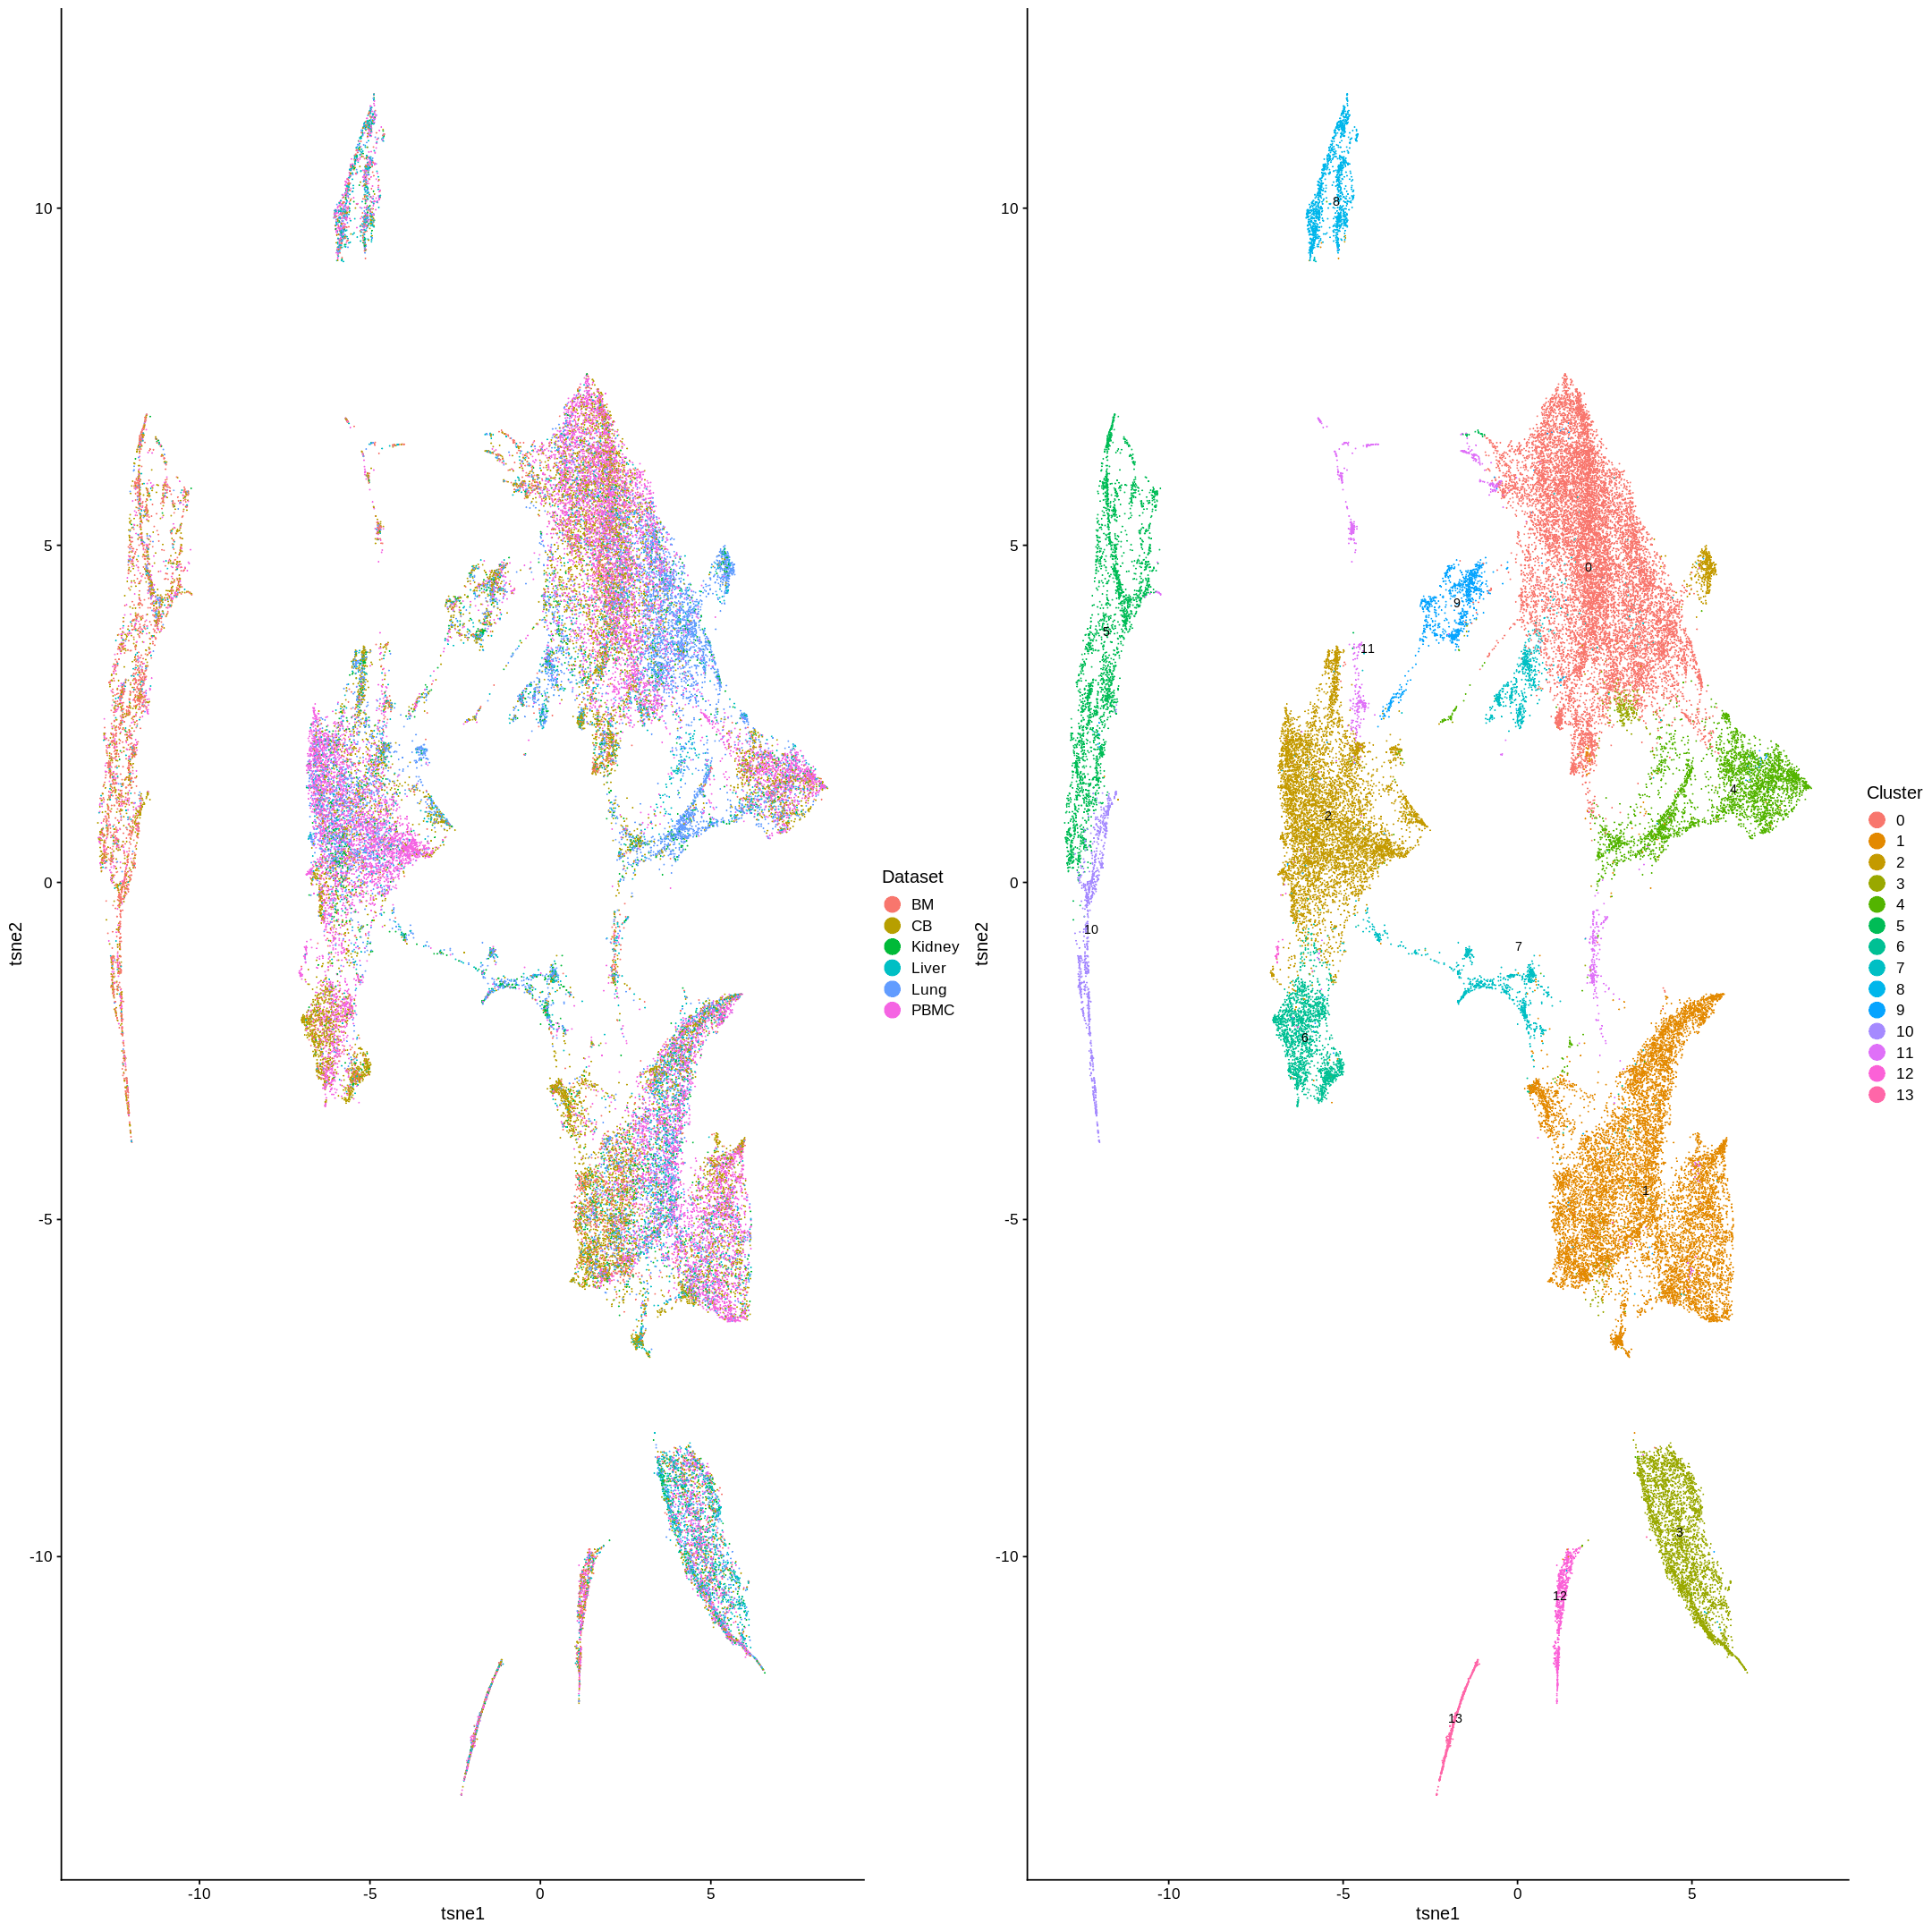

In [22]:
p <- plotByDatasetAndCluster(liger, return.plots = T)
plot_grid(p[[1]], p[[2]])

In [23]:
WH <- list()
WVH <- list()
mat <- list()

for(i in 1:6){
WH[[i]] <- t(liger@W)%*%t(liger@H.norm[colnames(seur.TPM_list[[i]]),])
#WH_PBMC <- t(ifnb_liger@W)%*%t(ifnb_liger@H$PBMC_HCL)
WVH[[i]]<- (t(liger@W)+t(liger@V[[1]]))%*%t(liger@H.norm[colnames(seur.TPM_list[[i]]),])
#WVH_PBMC<- (t(ifnb_liger@W)+t(ifnb_liger@V$PBMC_HCL))%*%t(ifnb_liger@H$PBMC_HCL)
mat[[i]] <- seur.TPM_list[[i]][liger@var.genes,]
mat[[i]] <- as.matrix(mat[[i]])
#idx.sample <- sample(seq(dim(mat[[i]])[1]*dim(mat[[i]])[2]),2000)
#plot(as.vector(WVH[[i]])[idx.sample],as.vector(mat[[i]])[idx.sample])
#plot(as.vector(WH[[i]])[idx.sample],as.vector(mat[[i]])[idx.sample])

#cor(as.vector(WVH[[i]])[idx.sample],as.vector(mat[[i]])[idx.sample])
#cor(as.vector(WH[[i]])[idx.sample],as.vector(mat[[i]])[idx.sample])
}

In [24]:
new_mat <- Reduce(cbind,WH)

lst <- list()
for(i in seq(length(tissue_list))){
    lst[[i]] <- as.character(seur_list[[i]]$Celltype_used)
}
Celltype_used <-  Reduce(append,lst)

lst <- list()
for(i in seq(length(tissue_list))){
    lst[[i]] <- rep(tissue_list[i],ncol(seur_list[[i]]))
}
Batch <-  Reduce(append,lst)

In [25]:
## visualization on W*H.norm
new_seur <- CreateSeuratObject(new_mat)
new_seur$Celltype_used <- Celltype_used
new_seur$Batch <- Batch

In [26]:
## umap visualization
# standard log-normalization
new_seur <- NormalizeData(new_seur)
new_seur@assays$RNA@data <- new_seur@assays$RNA@counts
# choose ~1k variable features
new_seur <- FindVariableFeatures(new_seur, selection.method = "vst", nfeatures = 500)
# standard scaling (no regression)
new_seur <- ScaleData(new_seur)
# Run PCA, select 13 PCs for tSNE visualization and graph-based clustering
new_seur<- RunPCA(new_seur, verbose = FALSE)

new_seur <- FindNeighbors(new_seur, dims = 1:25)
new_seur <- FindClusters(new_seur, resolution = 0.8)
new_seur <- RunUMAP(new_seur, dims = 1:50)

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 49604
Number of edges: 1561656

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9057
Number of communities: 27
Elapsed time: 15 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:13:15 UMAP embedding parameters a = 0.9922 b = 1.112

15:13:15 Read 49604 rows and found 50 numeric columns

15:13:15 Using Annoy for neighbor search, n_neighbors = 30

15:13:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:13:27 Writing NN index file to temp file /tmp/RtmpYty0jD/file770b4620b34d

15:13:27 Searching Annoy index using 1 thread, search_k = 3000

15:13:51 Annoy recall = 100%

15:13:51 Commencing smooth kNN distance calibration using 1 thread

15:13:54 Initializing f

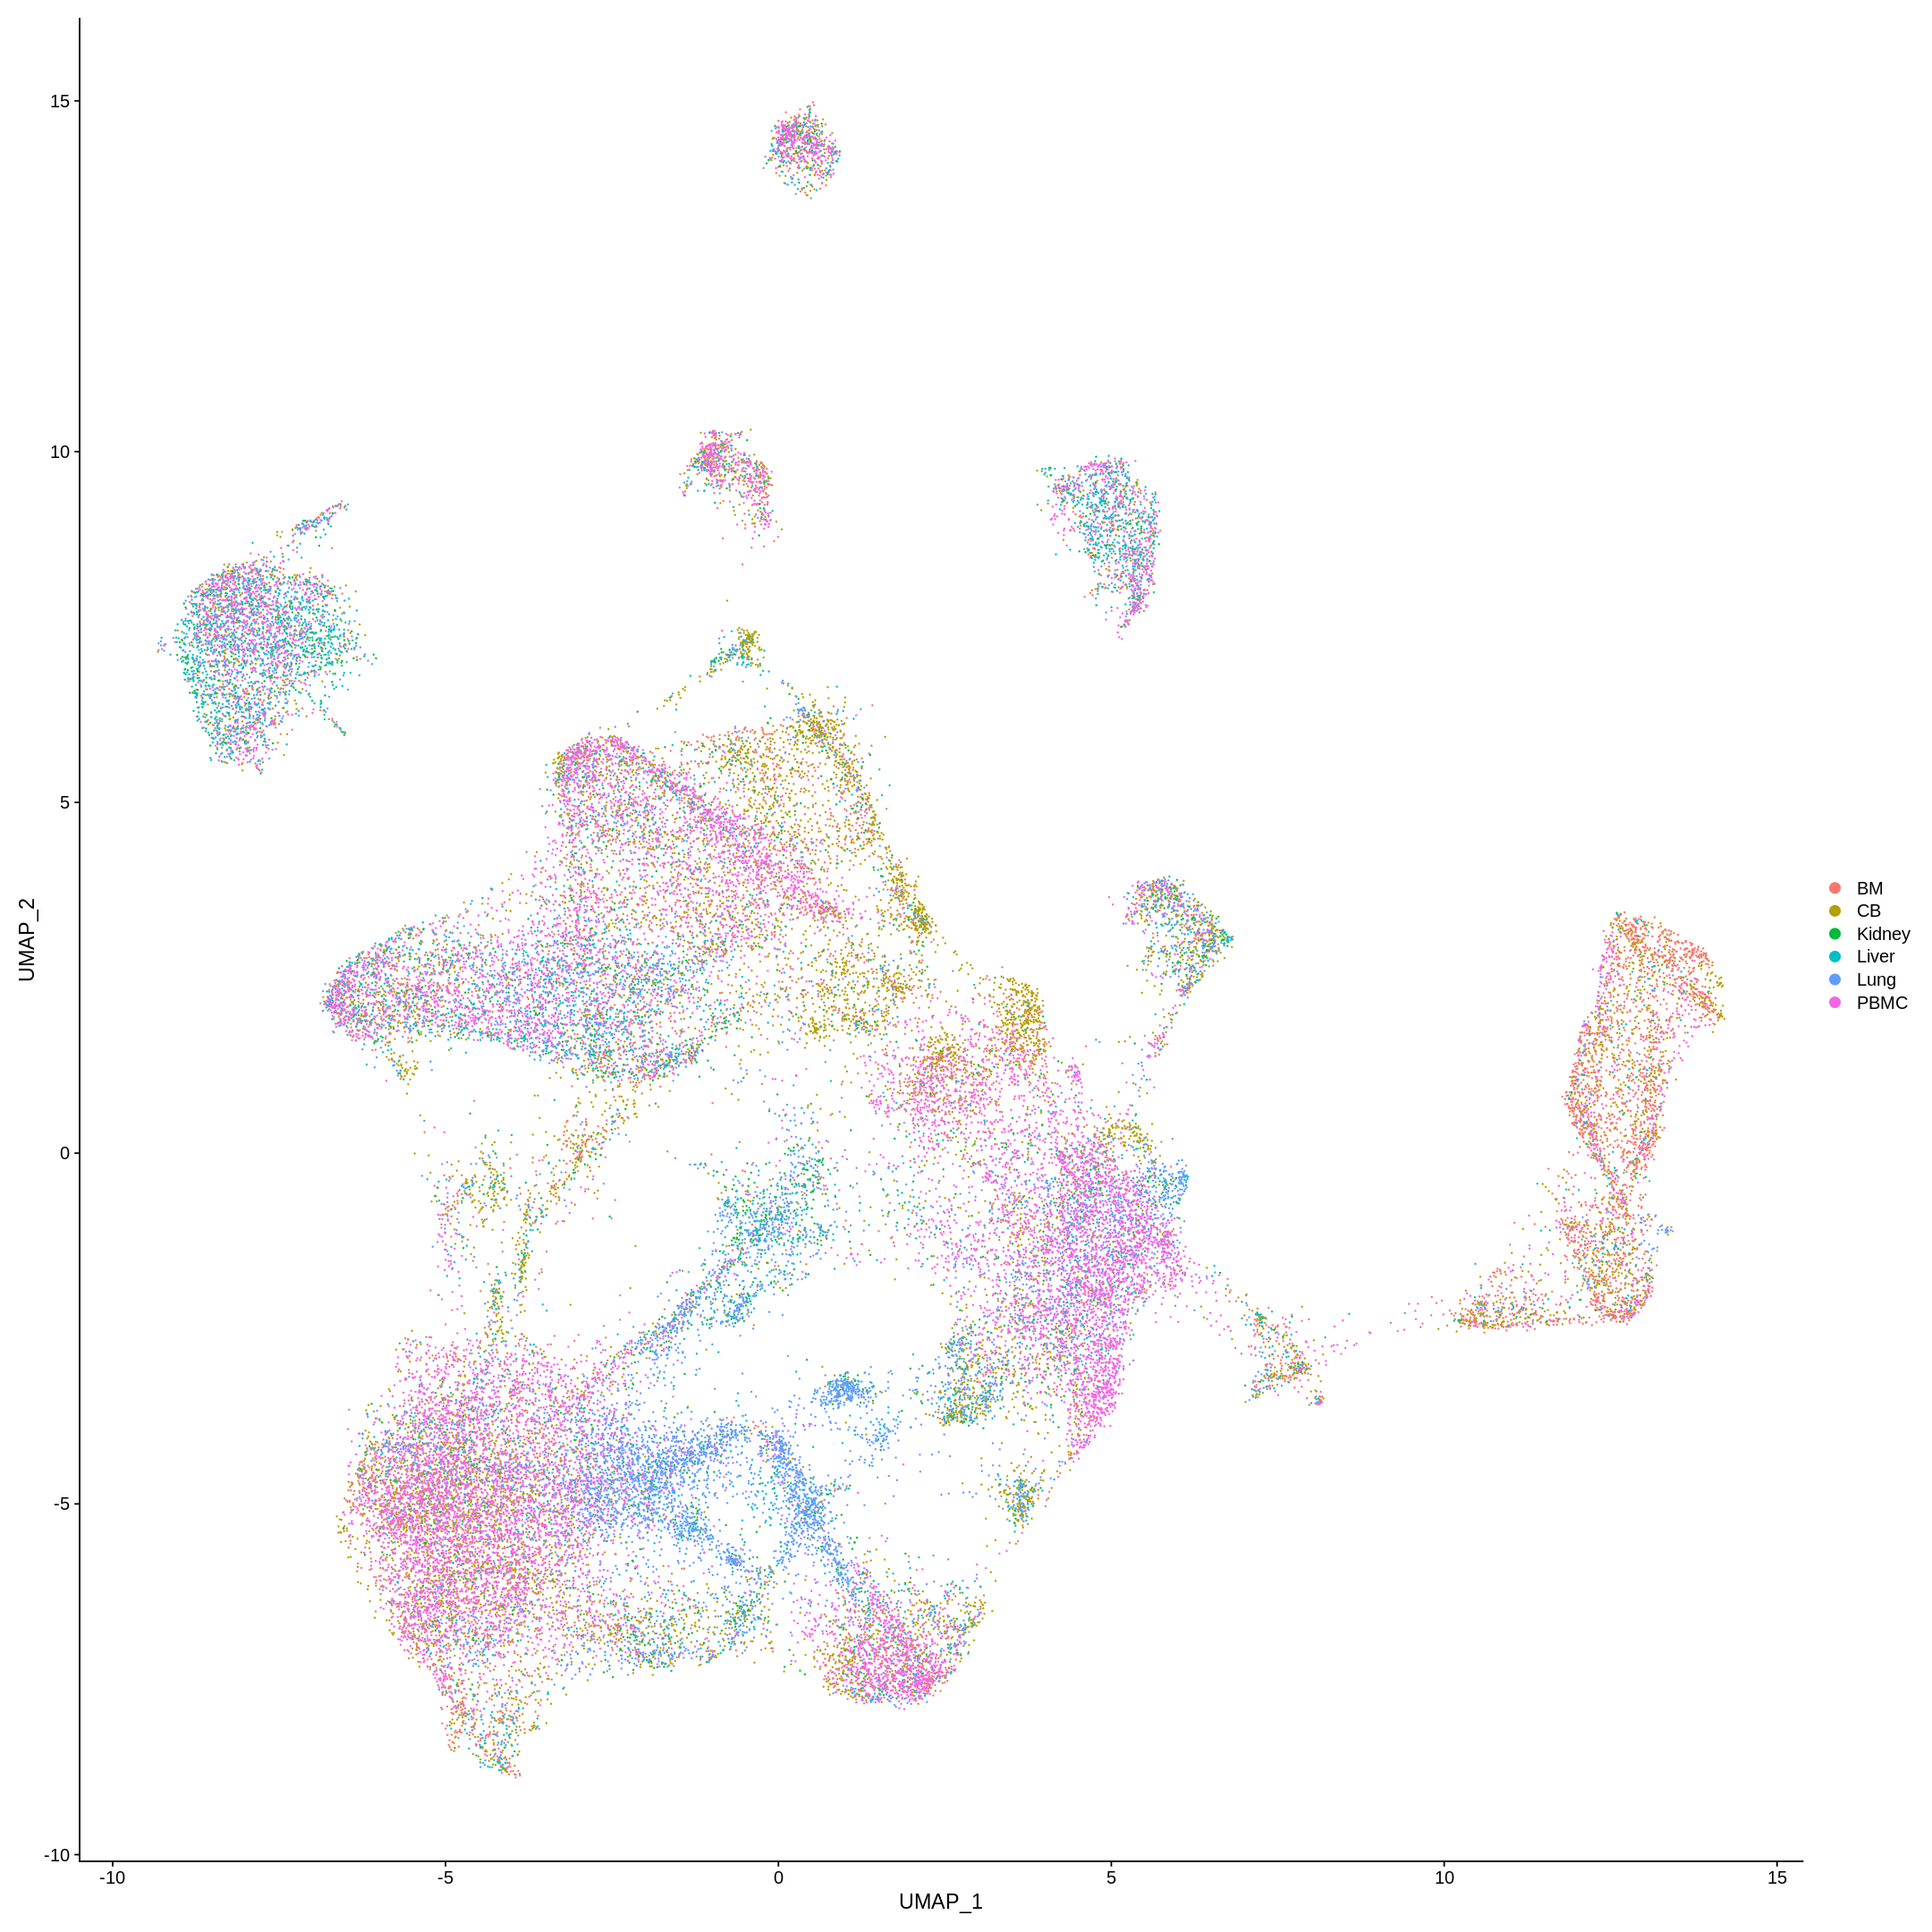

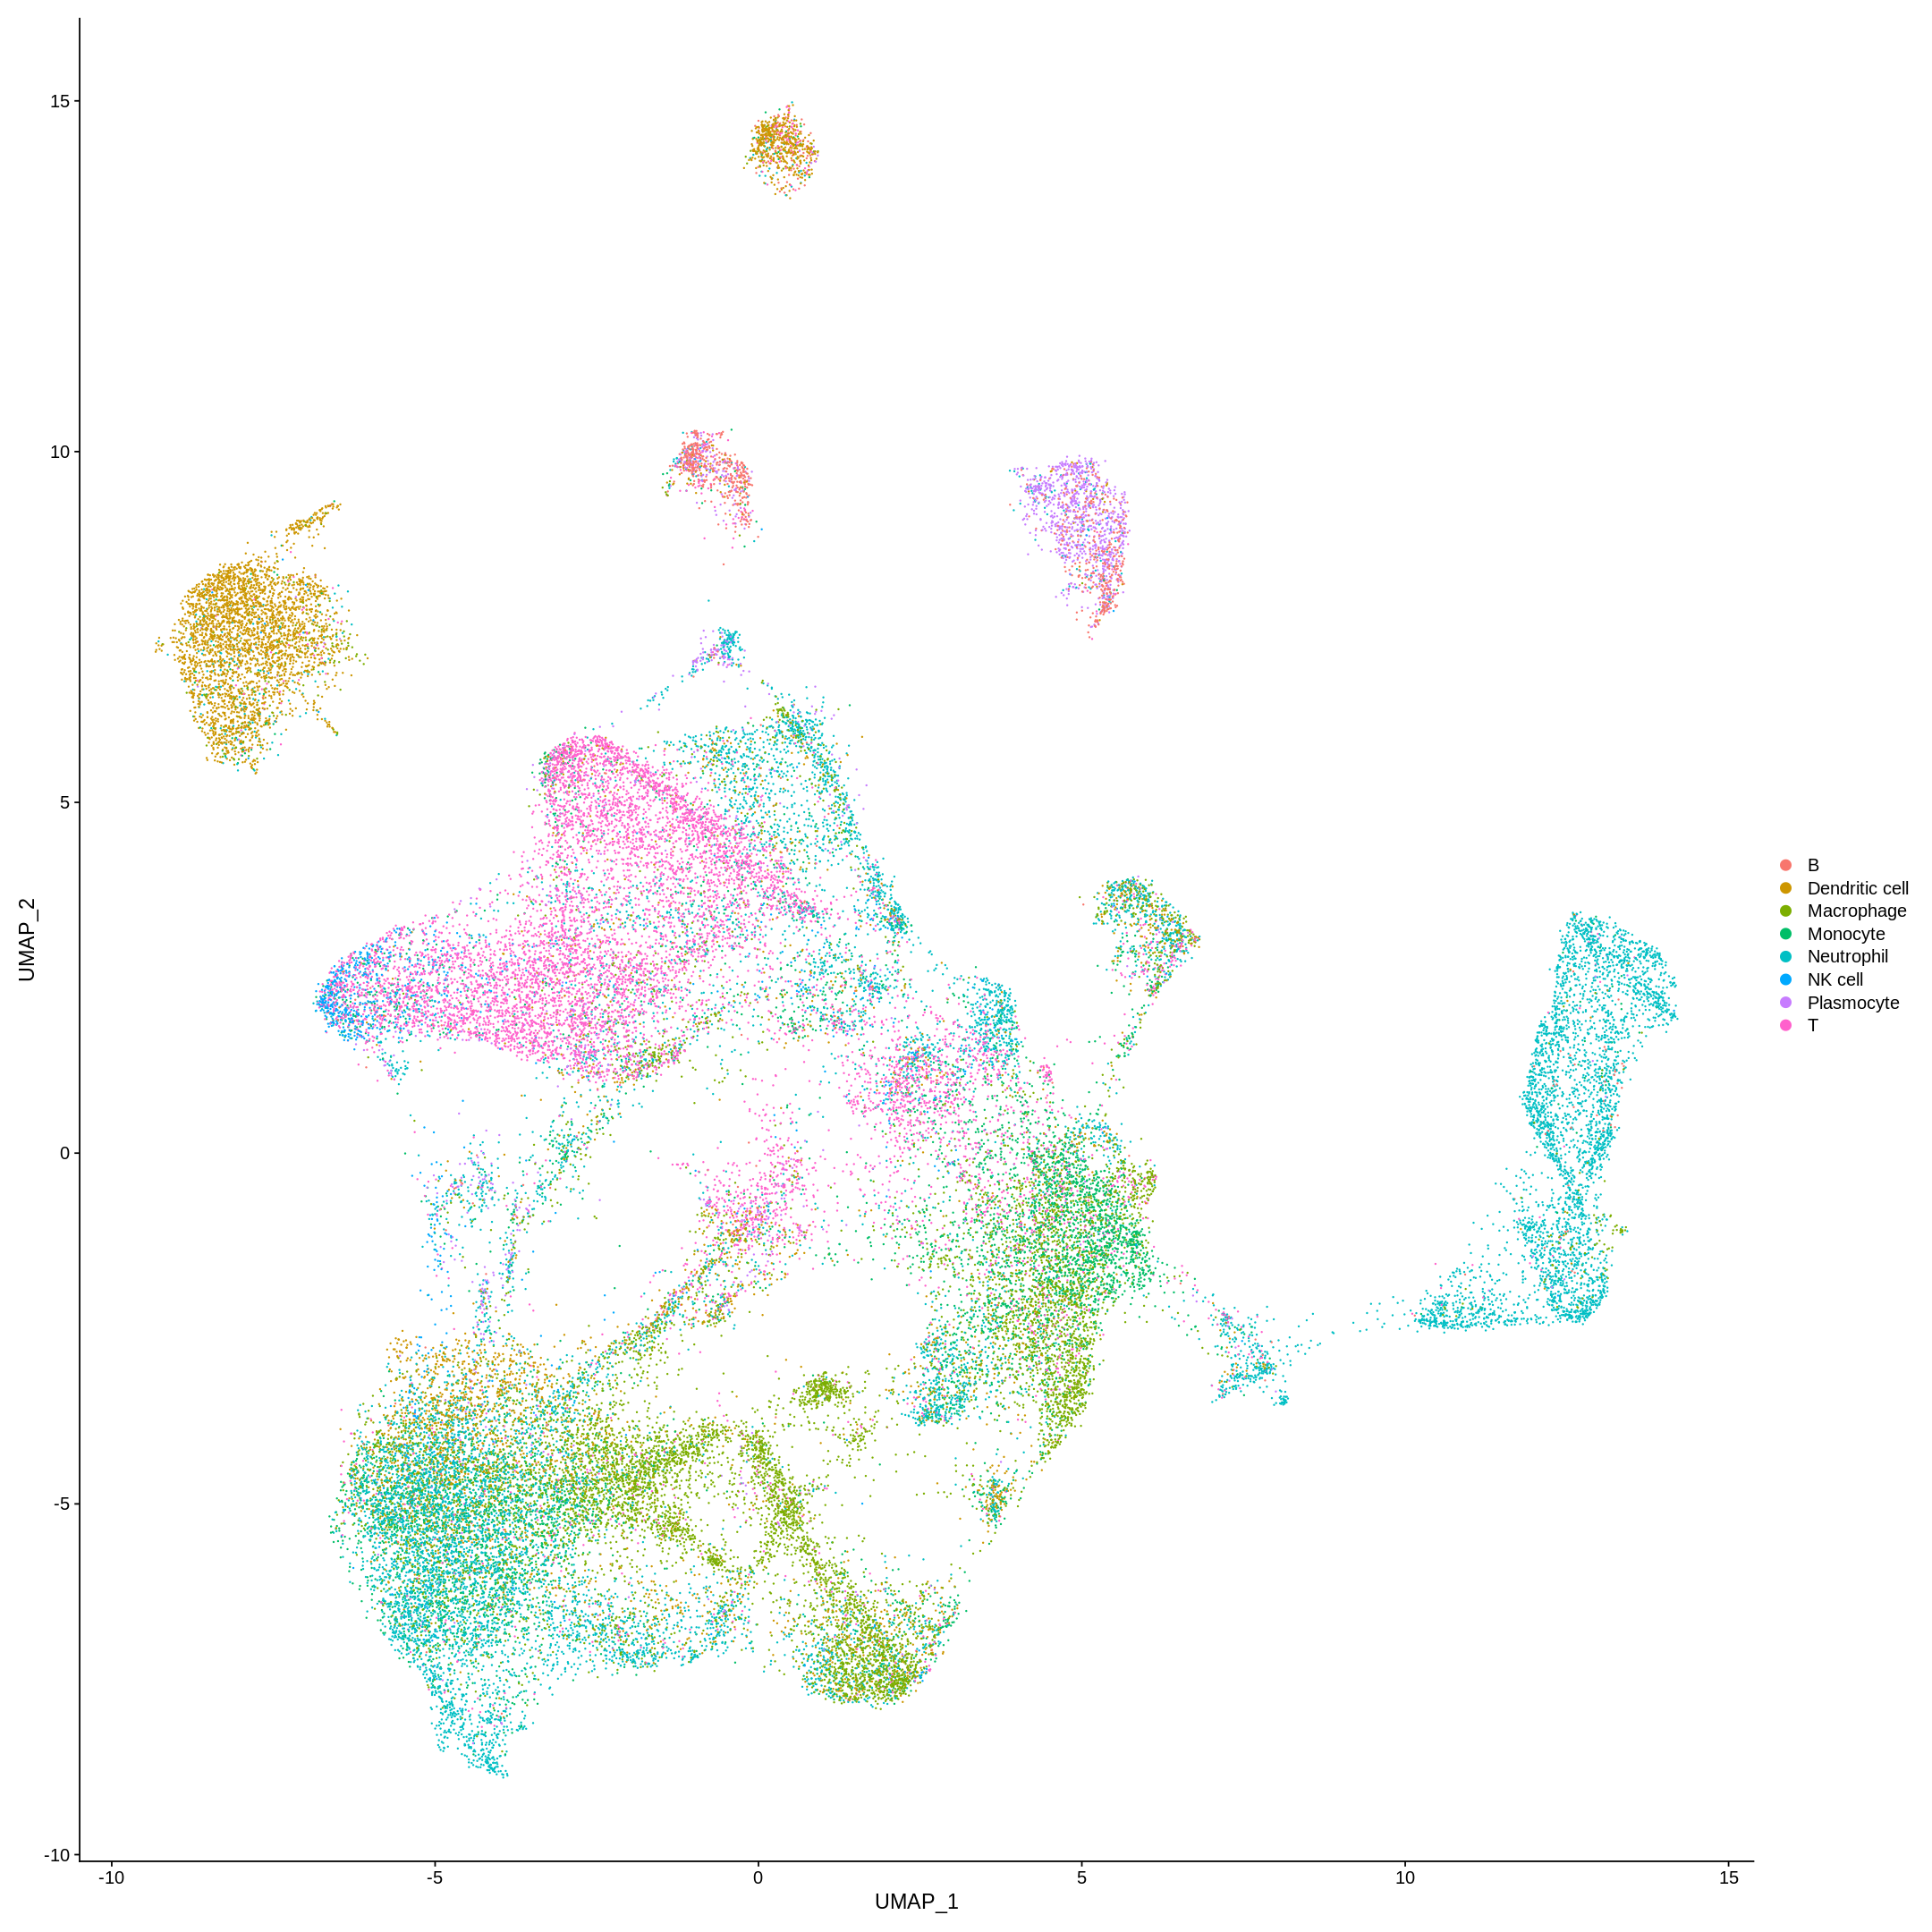

In [27]:
DimPlot(new_seur,group.by = 'Batch')
DimPlot(new_seur,group.by = 'Celltype_used')
#saveRDS(new_seur,"/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/liger_obj/BatchCorrected_HCL_seur.rds")

In [28]:
#new_seur<-readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/liger_obj/BatchCorrected_HCL_seur.rds")
new_split <- SplitObject(new_seur,split.by = 'Batch')

In [32]:
for(i in seq(length(tissue_list))){
    p1 <- DimPlot( new_split[[i]] , group.by='Celltype_used')+ ggtitle(paste0(tissue_list[i],", Batch Corrected"))
    p2 <- DimPlot( seur_list[[i]] , group.by='Celltype_used')+ ggtitle(paste0(tissue_list[i],", Raw"))
    plot_grid(p1, p2)
    ggsave(paste0('/gpfs/ysm/pi/zhao-data/wd262/sc_immune/plots/liger/cmp_BC_vs_raw/cmp_',tissue_list[i],'.jpg',sep=''), width = 8, height = 4)
}

In [35]:
W_tilde <- list()

for(i in seq(length(tissue_list))){
    Idents(new_split[[i]]) <- "Celltype_used"
    new_split[[i]] <- NormalizeData(new_split[[i]])
    W_tilde[[i]] <- as.matrix(AverageExpression(new_split[[i]],slot='data')$RNA)
}

Finished averaging RNA for cluster Plasmocyte

Finished averaging RNA for cluster T

Finished averaging RNA for cluster B

Finished averaging RNA for cluster Macrophage

Finished averaging RNA for cluster Monocyte

Finished averaging RNA for cluster Neutrophil

Finished averaging RNA for cluster NK cell

Finished averaging RNA for cluster Dendritic cell

Finished averaging RNA for cluster Neutrophil

Finished averaging RNA for cluster Monocyte

Finished averaging RNA for cluster NK cell

Finished averaging RNA for cluster Dendritic cell

Finished averaging RNA for cluster T

Finished averaging RNA for cluster B

Finished averaging RNA for cluster Plasmocyte

Finished averaging RNA for cluster Macrophage

Finished averaging RNA for cluster T

Finished averaging RNA for cluster Dendritic cell

Finished averaging RNA for cluster B

Finished averaging RNA for cluster Plasmocyte

Finished averaging RNA for cluster Neutrophil

Finished averaging RNA for cluster Plasmocyte

Finished averaging

In [7]:
YSG_rst <- readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/sc_immune/write/V2/gene.list.rds")
celltype_list <- readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/sc_immune/write/V2/celltype.list.rds")

In [8]:
tissue_list_2 <- c(6,2,1)

In [9]:
W_tilde_orig <- list()
for(i in seq(length(tissue_list_2))){
    sub_seur <- seur_list[[tissue_list_2[i]]]
    Idents(sub_seur) <- "Celltype_used"
    sub_seur <- subset(sub_seur,Celltype_used %in% c("B", "Monocyte", "NK cell", "T"))
    print(table(sub_seur$Celltype_used))
    sub_seur <- NormalizeData(sub_seur)
    W_tilde_orig[[i]] <- as.matrix(AverageExpression(sub_seur,slot='data')$RNA)
    print(length(intersect(YSG_rst,rownames(W_tilde_orig[[i]]))))
    W_tilde_orig[[i]] <- W_tilde_orig[[i]][YSG_rst,]
}


       B Monocyte  NK cell        T 
     537     2507      530     4570 


Finished averaging RNA for cluster B

Finished averaging RNA for cluster T

Finished averaging RNA for cluster Monocyte

Finished averaging RNA for cluster NK cell



[1] 986

       B Monocyte  NK cell        T 
     154     2557      272      642 


Finished averaging RNA for cluster Monocyte

Finished averaging RNA for cluster NK cell

Finished averaging RNA for cluster T

Finished averaging RNA for cluster B



[1] 986

       B Monocyte  NK cell        T 
     180     1061       50      183 


Finished averaging RNA for cluster T

Finished averaging RNA for cluster B

Finished averaging RNA for cluster Monocyte

Finished averaging RNA for cluster NK cell



[1] 986


In [19]:
table(seur_list[[6]]$Celltype_used)


             B Dendritic cell     Macrophage       Monocyte     Neutrophil 
           537           1775           3268           2507           3167 
       NK cell     Plasmocyte              T 
           530            205           4570 

In [11]:

PlotCompare <- function(i,j,W_tilde){
    W_tilde_A <- W_tilde[[i]]
    W_tilde_B <- W_tilde[[j]]
    celltype.intersect <- intersect(colnames(W_tilde_A),colnames(W_tilde_B))
    df.cor1 <- melt(W_tilde_A[,celltype.intersect],value.name = "tissue1")
    df.cor2 <- melt(W_tilde_B[,celltype.intersect],value.name = "tissue2")
    df.cor <- cbind(df.cor1,tissue2=df.cor2[,3])
    return(df.cor)
}    


In [31]:
for(i in 1:5){
    for(j in (i+1):6){
       df.cor <- PlotCompare(i,j) 
       ggplot(df.cor,aes(x=tissue1,y=tissue2))+geom_point(aes(colour = factor(Var2)),size=.03)+
        xlab(tissue_list[i])+ylab(tissue_list[j])+coord_fixed(ratio = 1)+
        xlim(0,300)+ ylim(0,300) 
       ggsave(paste0('/gpfs/ysm/pi/zhao-data/wd262/sc_immune/plots/liger/cmp_2tissue/cmp_',tissue_list[i],"_",tissue_list[j],'.jpg',sep=''), width = 6, height = 3)

    }
}


In [20]:
tissue_list

[1] "BM"     "CB"     "Kidney" "Liver"  "Lung"   "PBMC"

In [38]:
target_idx = 6
ref_idx = 2

df.cor <- PlotCompare(target_idx,ref_idx,W_tilde)
df.cor$ratio <- df.cor$tissue2/df.cor$tissue1

In [13]:
unique(df.cor$Var2)

[1] B              T              Macrophage     Dendritic cell Neutrophil    
[6] NK cell        Plasmocyte    
Levels: B T Macrophage Dendritic cell Neutrophil NK cell Plasmocyte

[1] 3


Warning message:
“Removed 1 rows containing missing values (geom_point).”


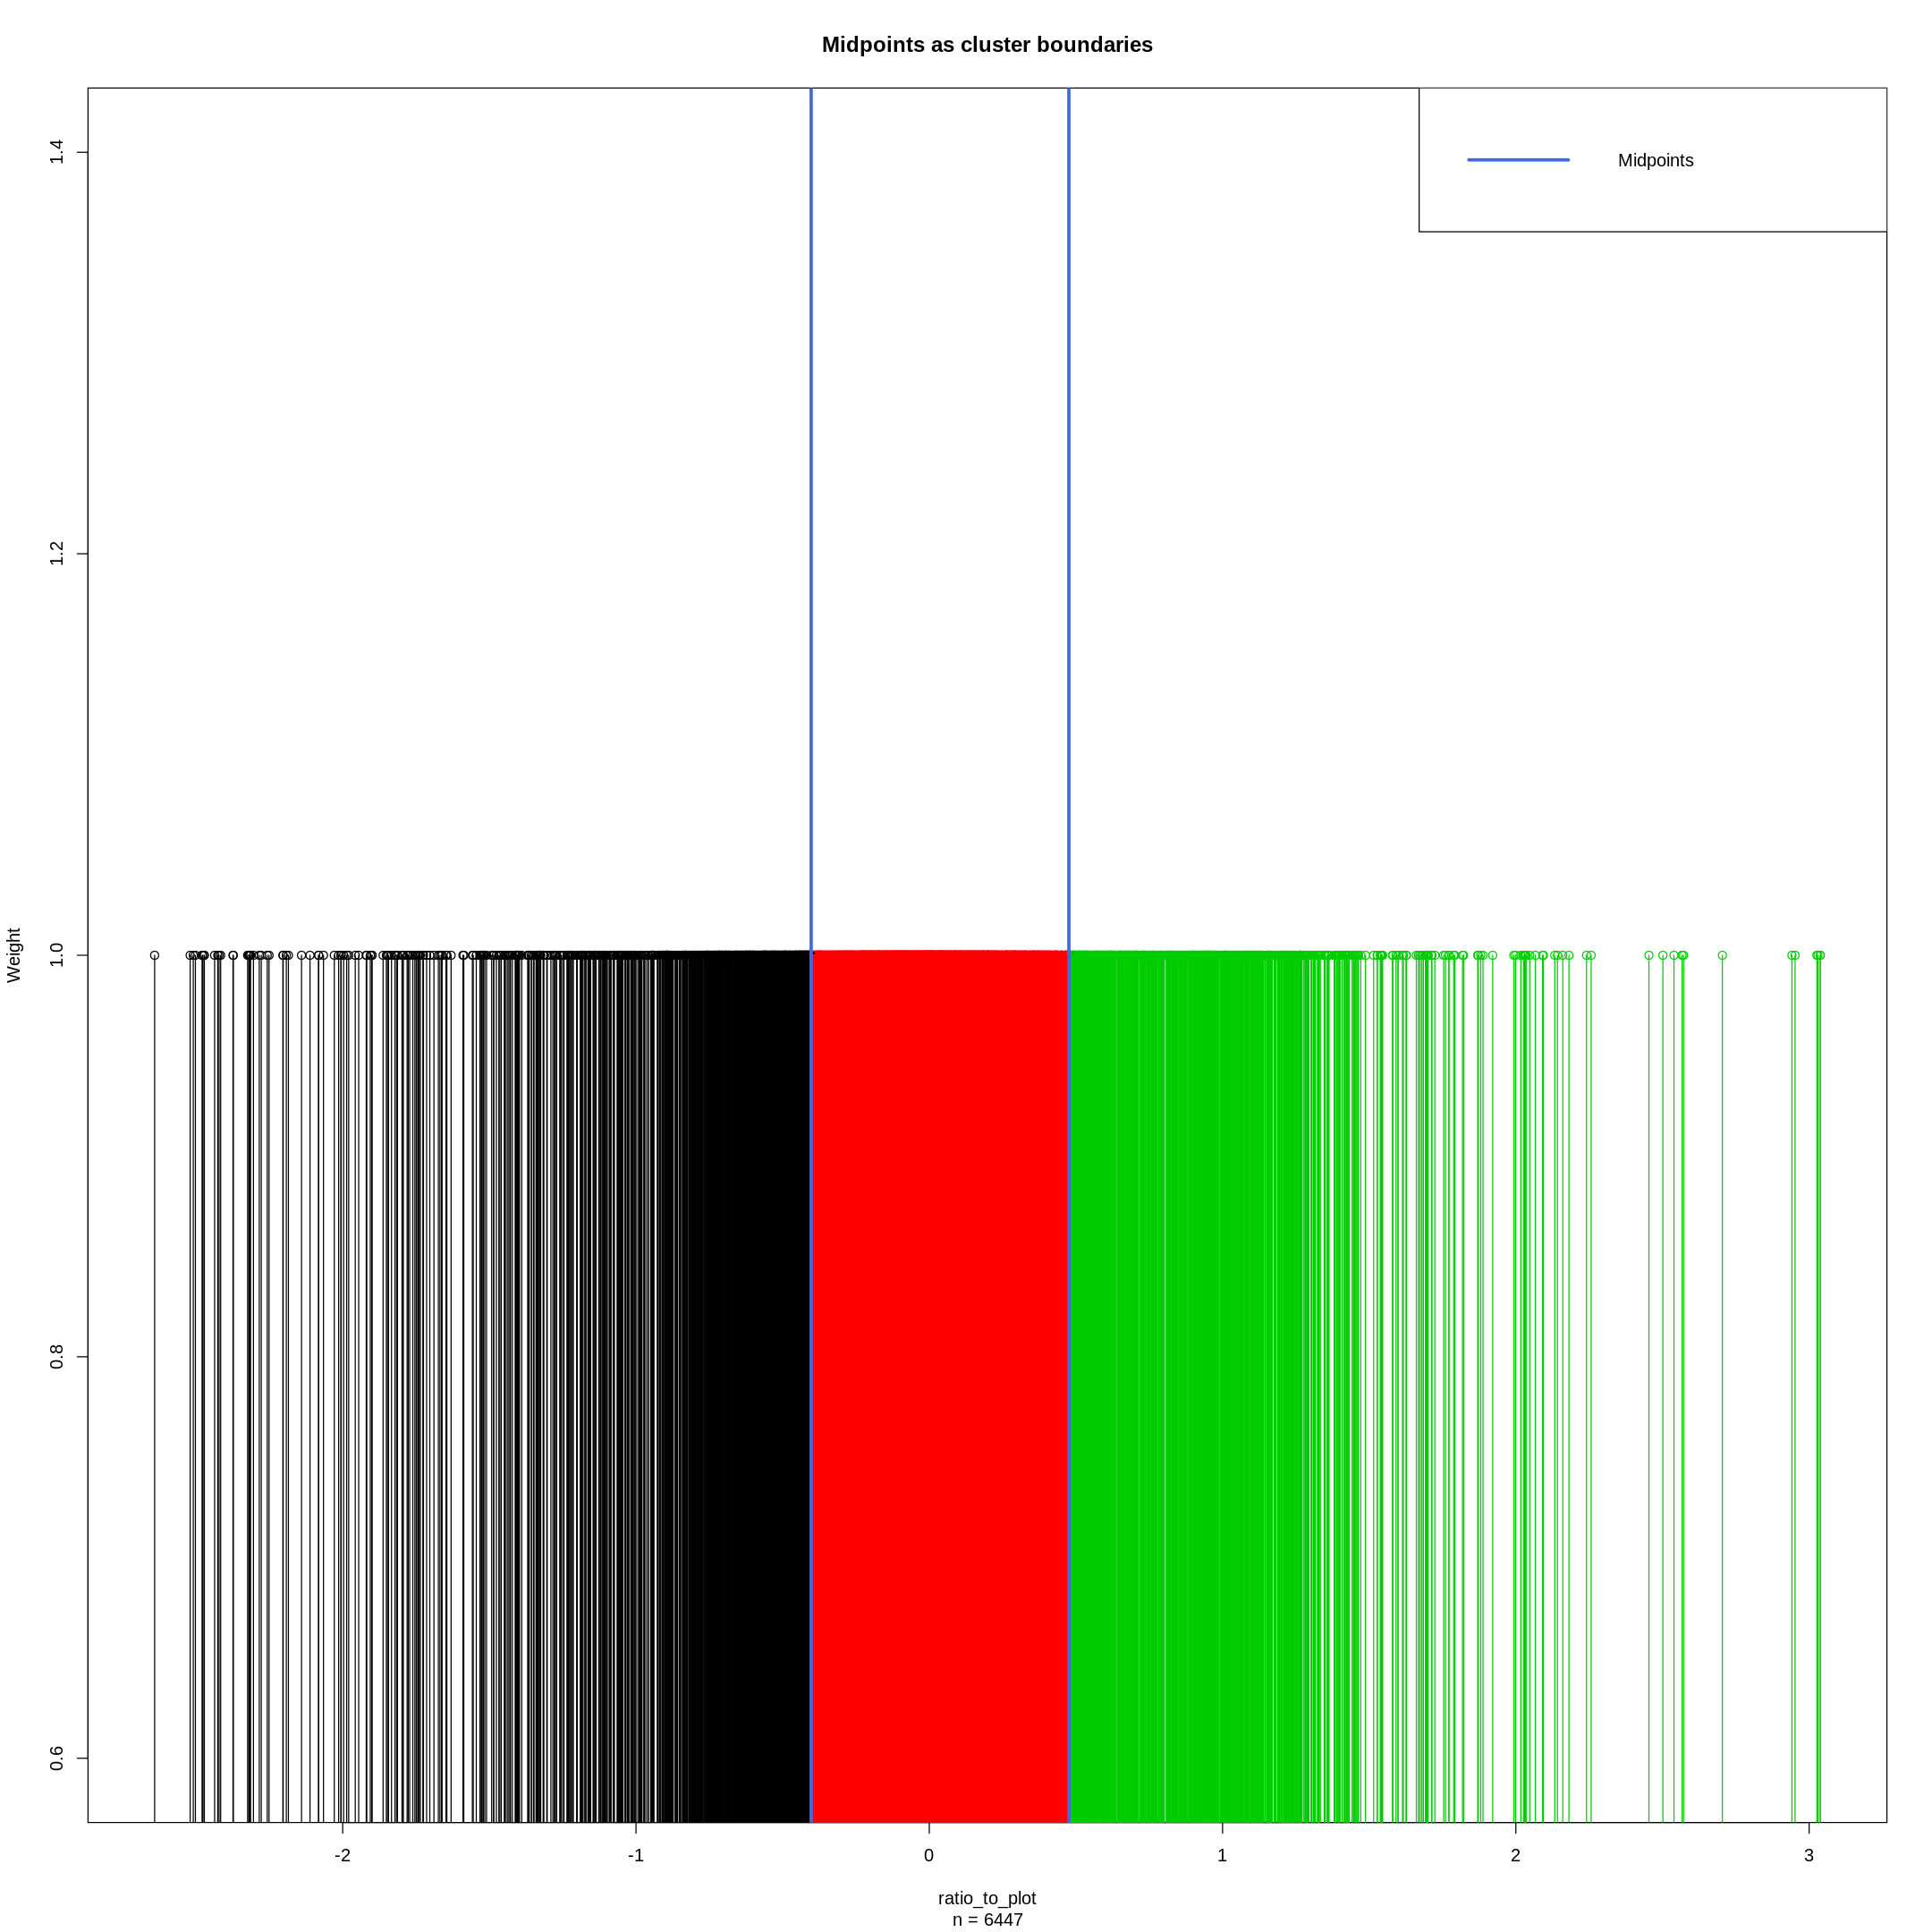

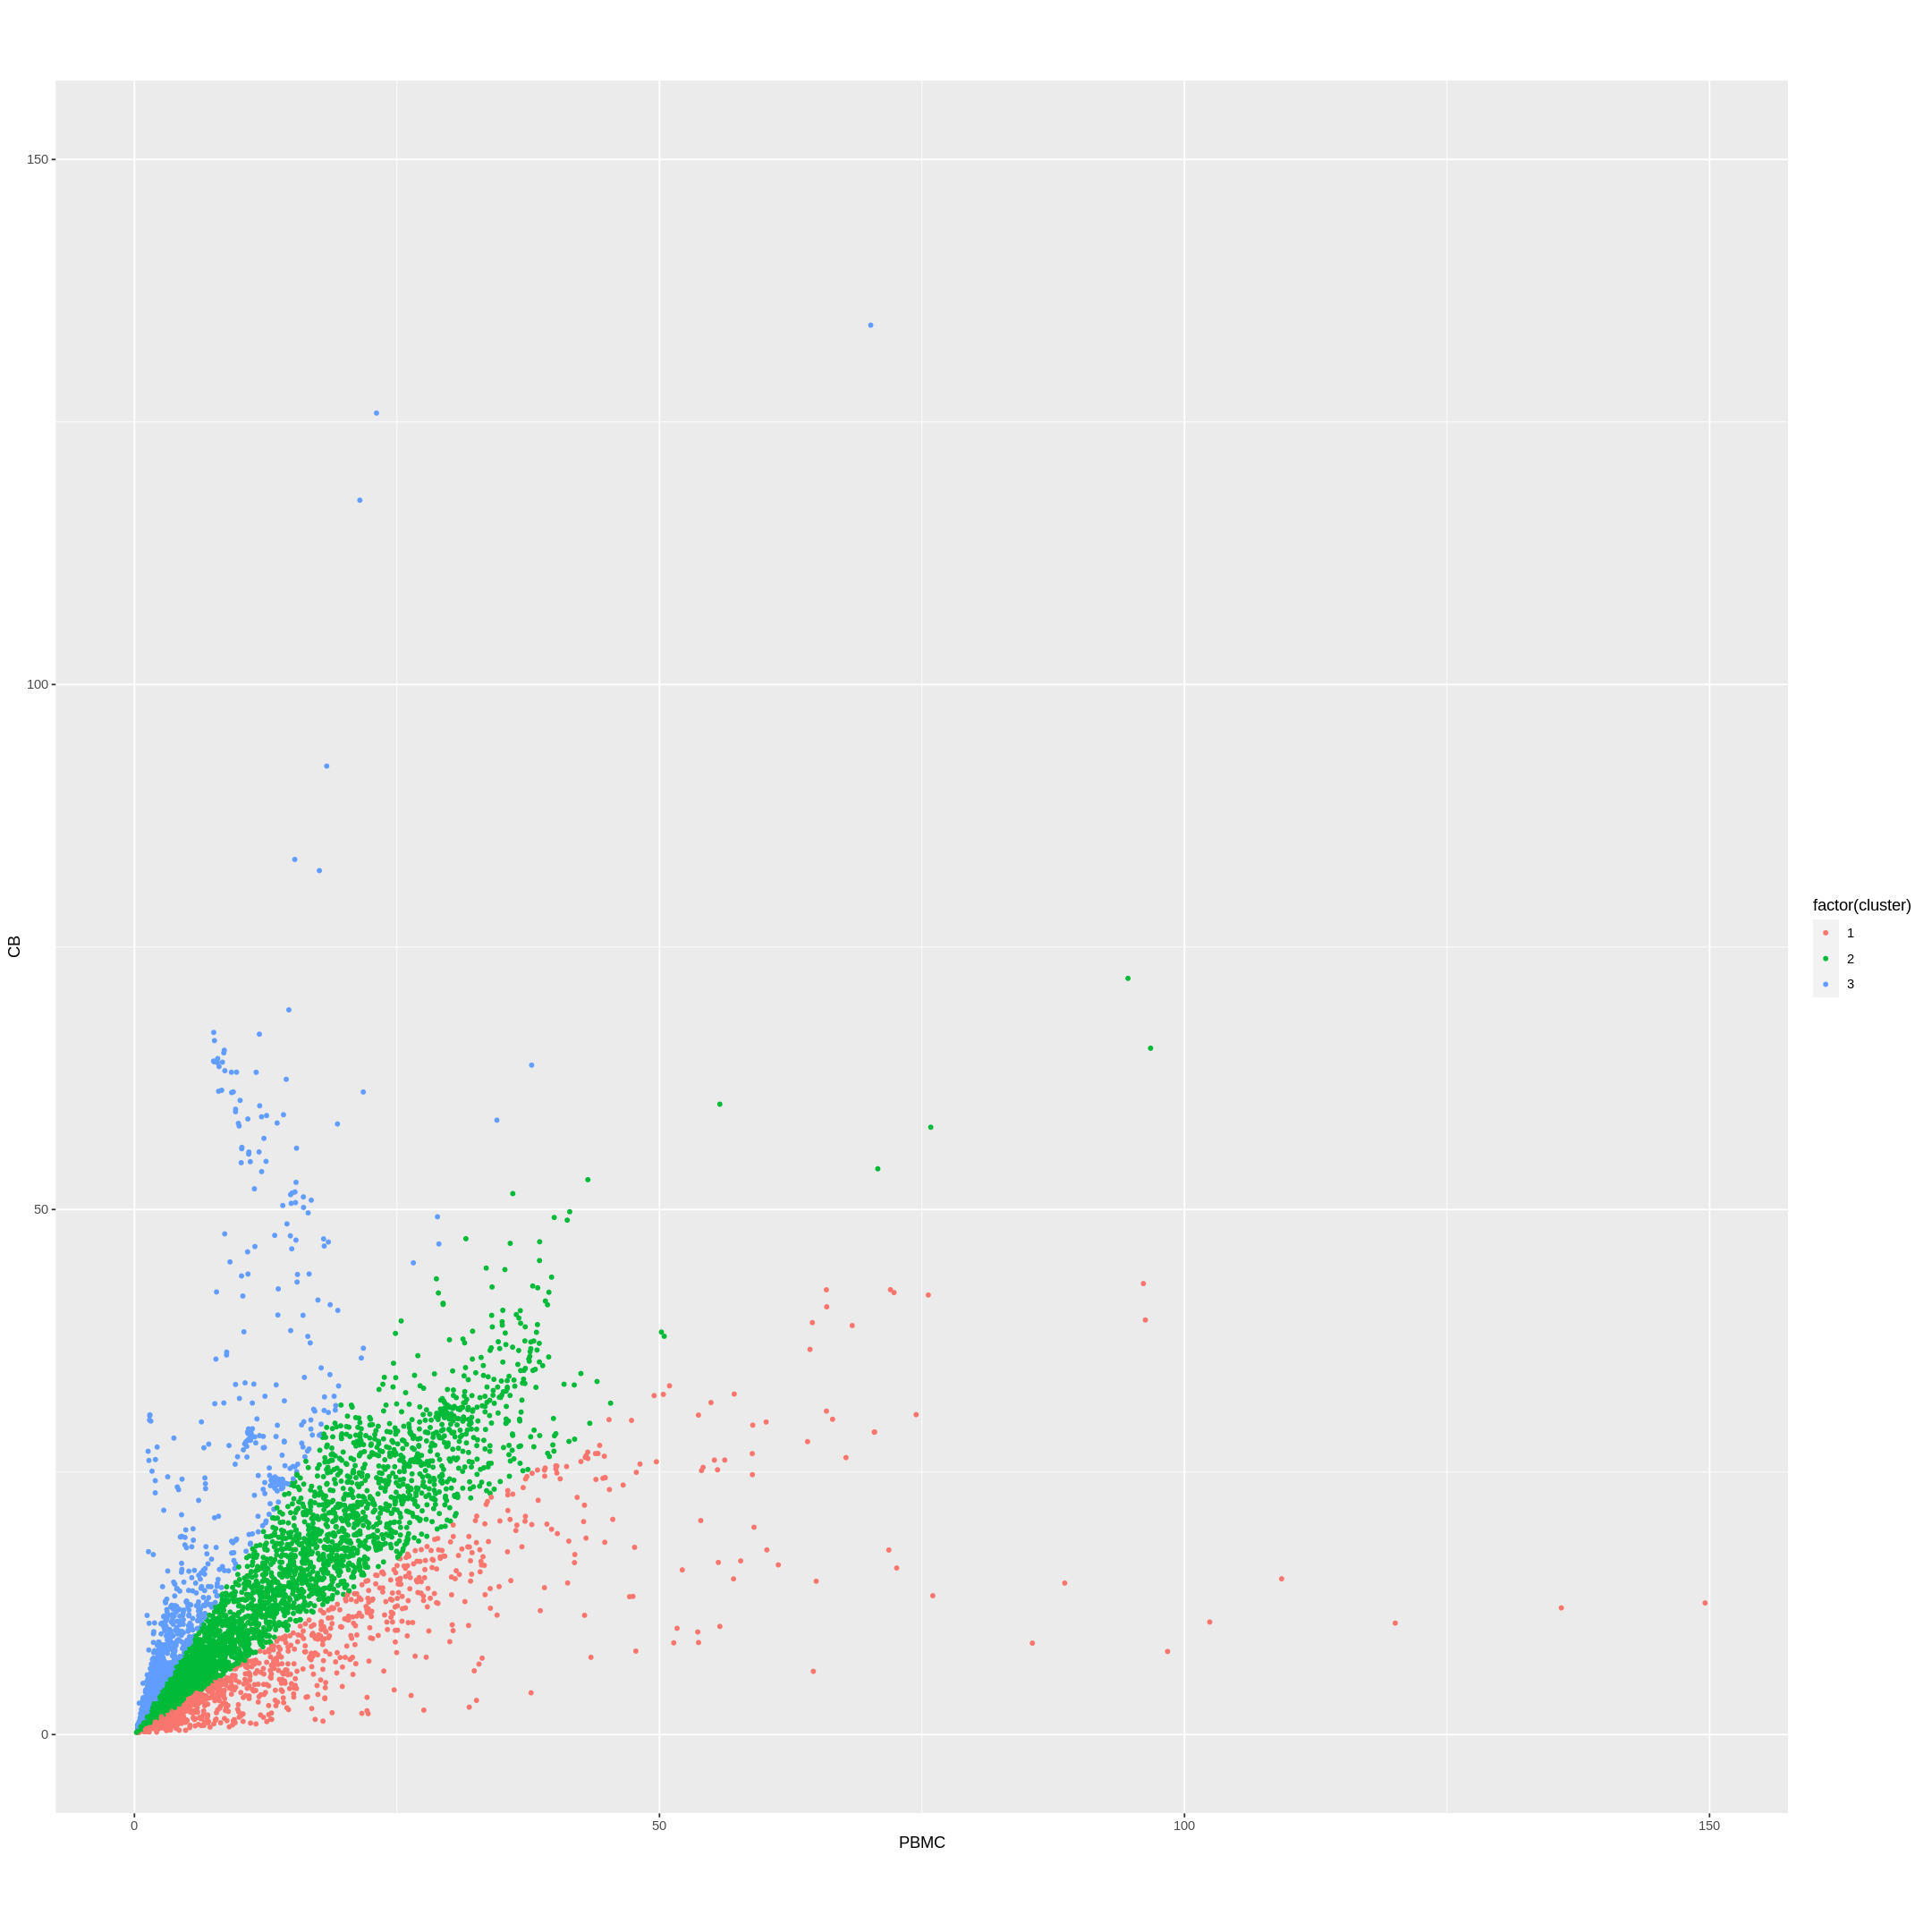

In [40]:
df.cor.plot <- df.cor[df.cor$Var2 %in% "Plasmocyte",]
df.cor.plot <- df.cor
ratio_to_plot <- log(df.cor.plot$ratio)
km <- Ckmeans.1d.dp(ratio_to_plot,k=3)
k=length(km$size)
print(k)
midpoints <- ahist(km, style="midpoints", data=ratio_to_plot, plot=FALSE)$breaks[2:k]
df.cor.plot$cluster <- km$cluster

plot(km, main="Midpoints as cluster boundaries")
abline(v=midpoints, col="RoyalBlue", lwd=3)
legend("topright", "Midpoints", lwd=3, col="RoyalBlue")

ggplot(df.cor.plot,aes(x=tissue1,y=tissue2))+geom_point(aes(colour = factor(cluster)),size=1)+
        xlab(tissue_list[target_idx])+ylab(tissue_list[ref_idx])+coord_fixed(ratio = 1)+
        xlim(0,150)+ ylim(0,150) 

In [44]:
head(df.cor.plot)


   1    2    3 
1070 4226 1151 

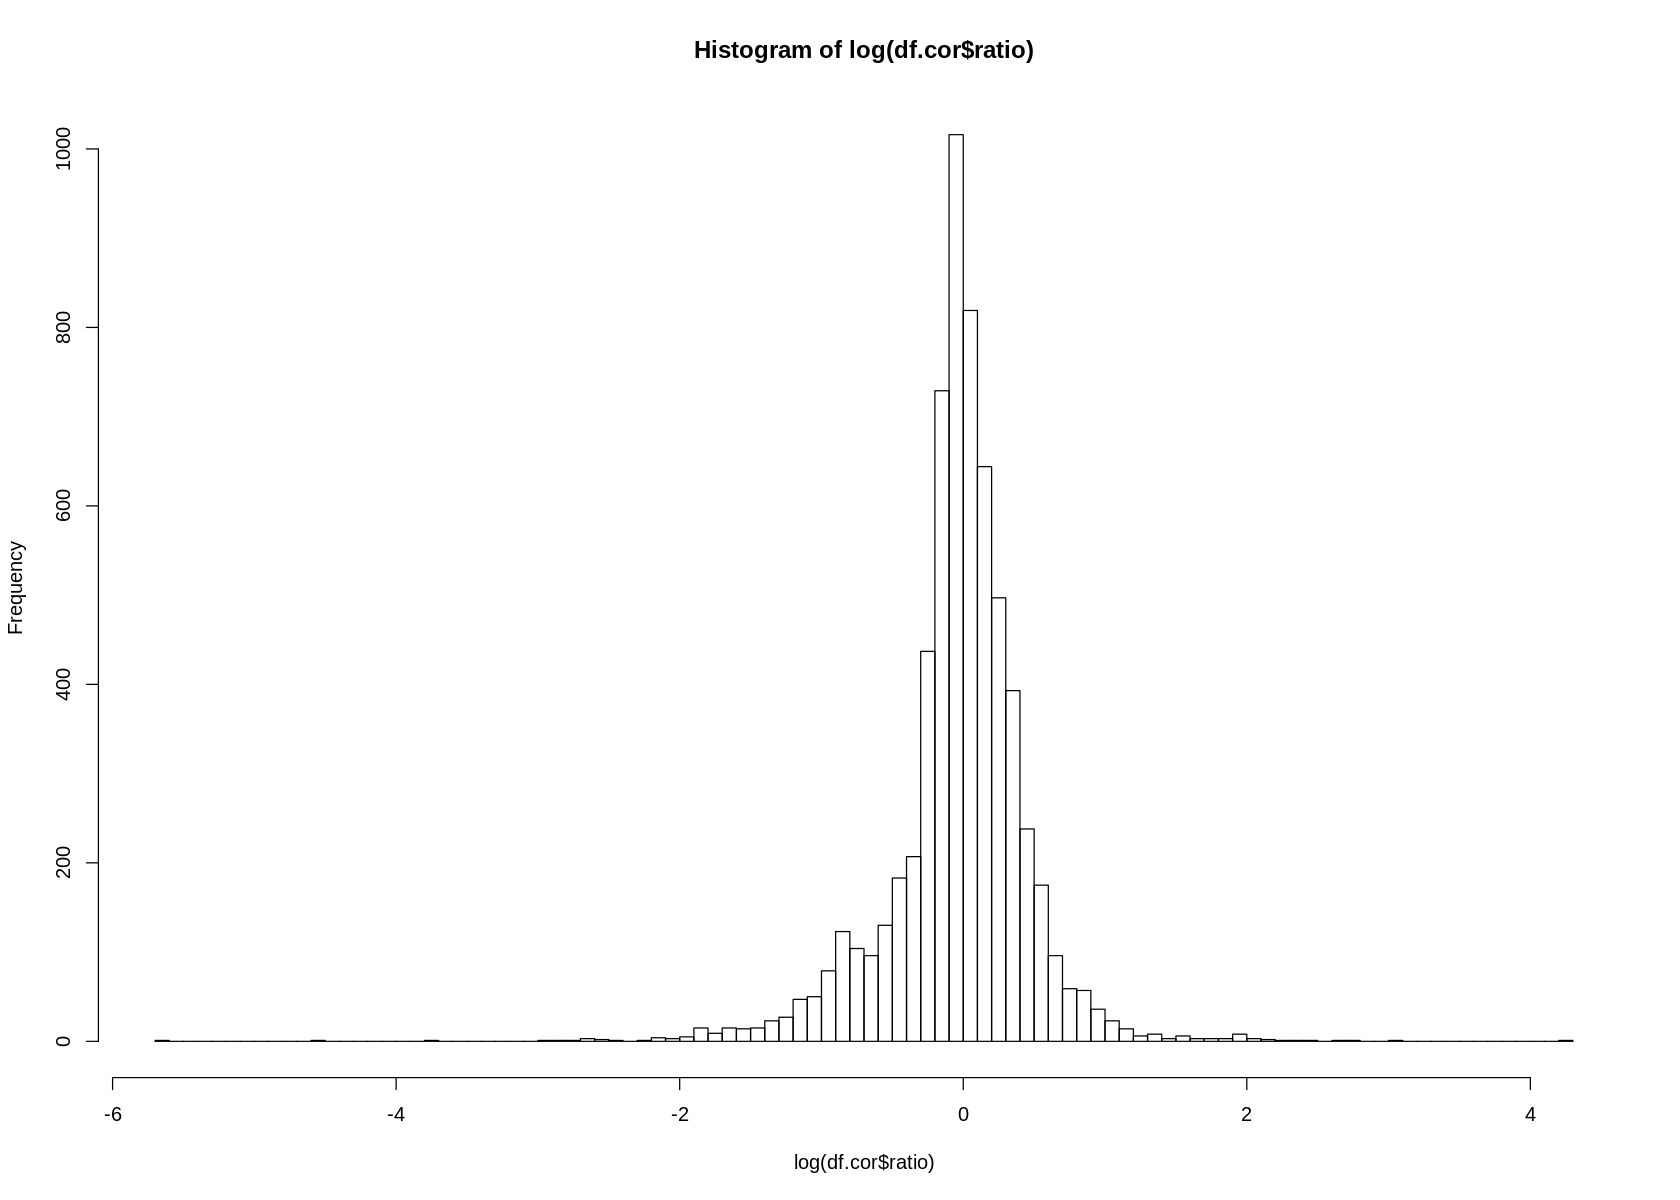

In [37]:
hist(log(df.cor$ratio),100)

[1] 0.09432049

[1] 0.09482759

[1] 0.09406694

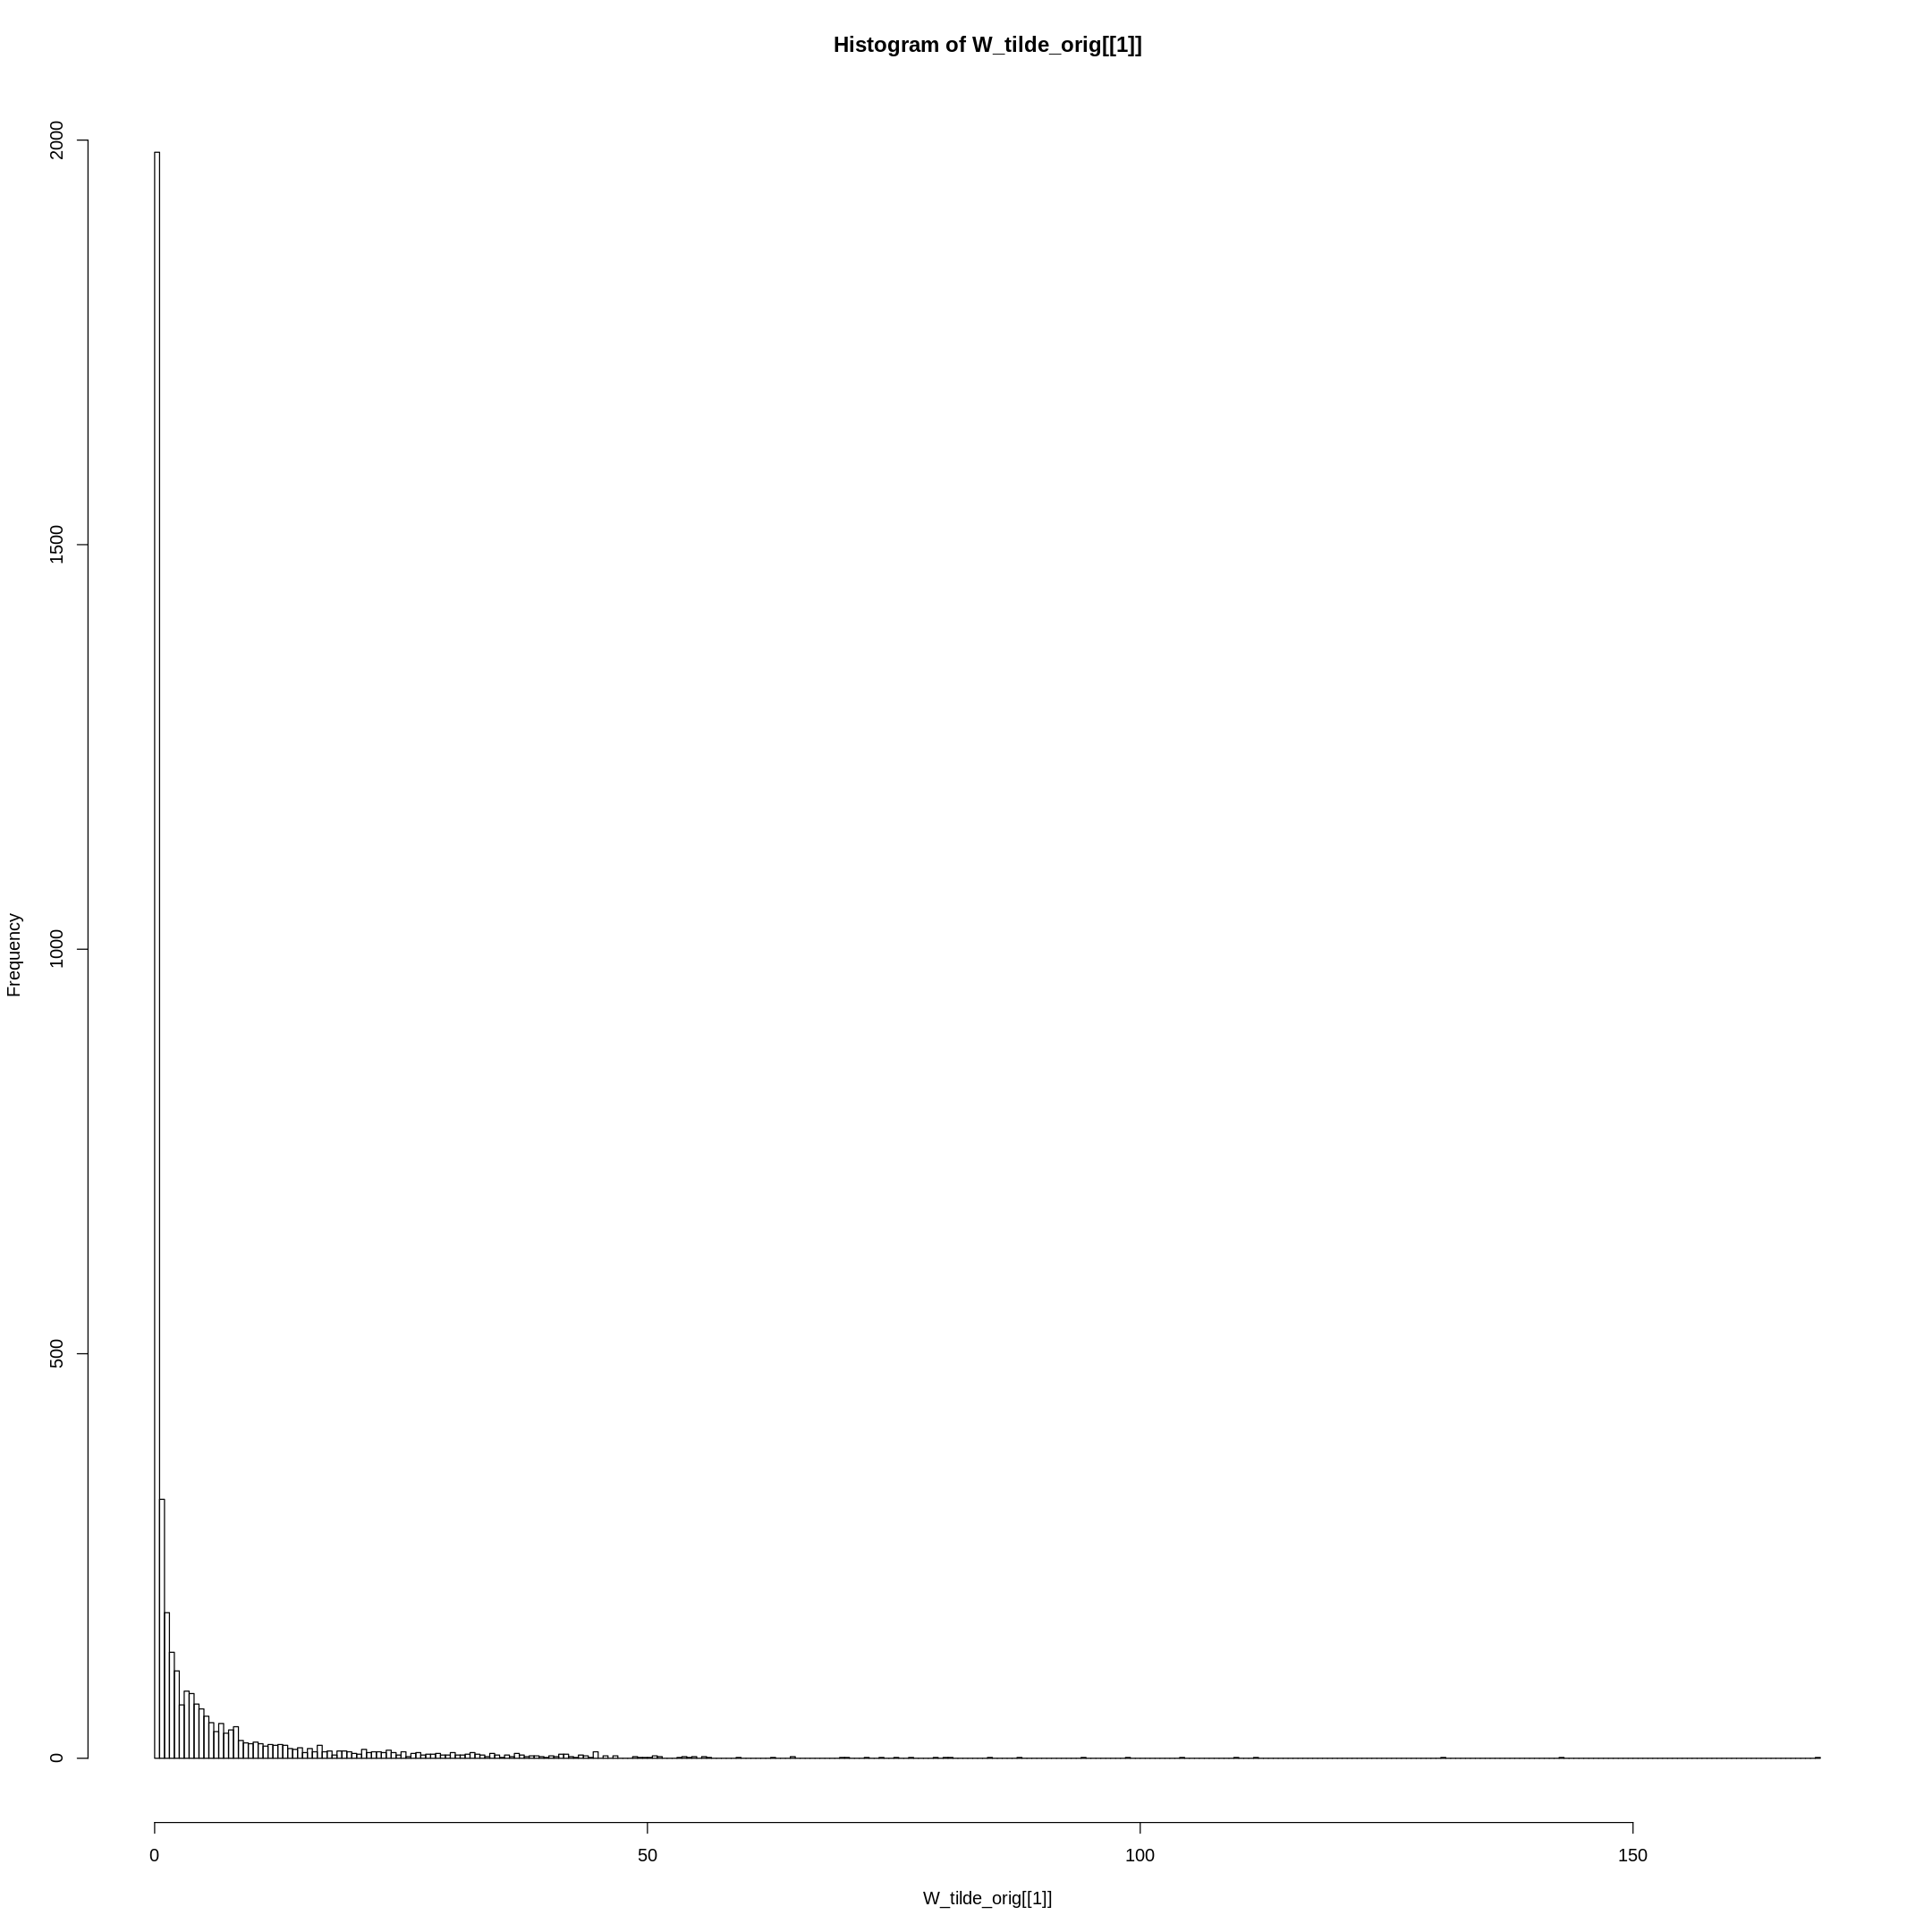

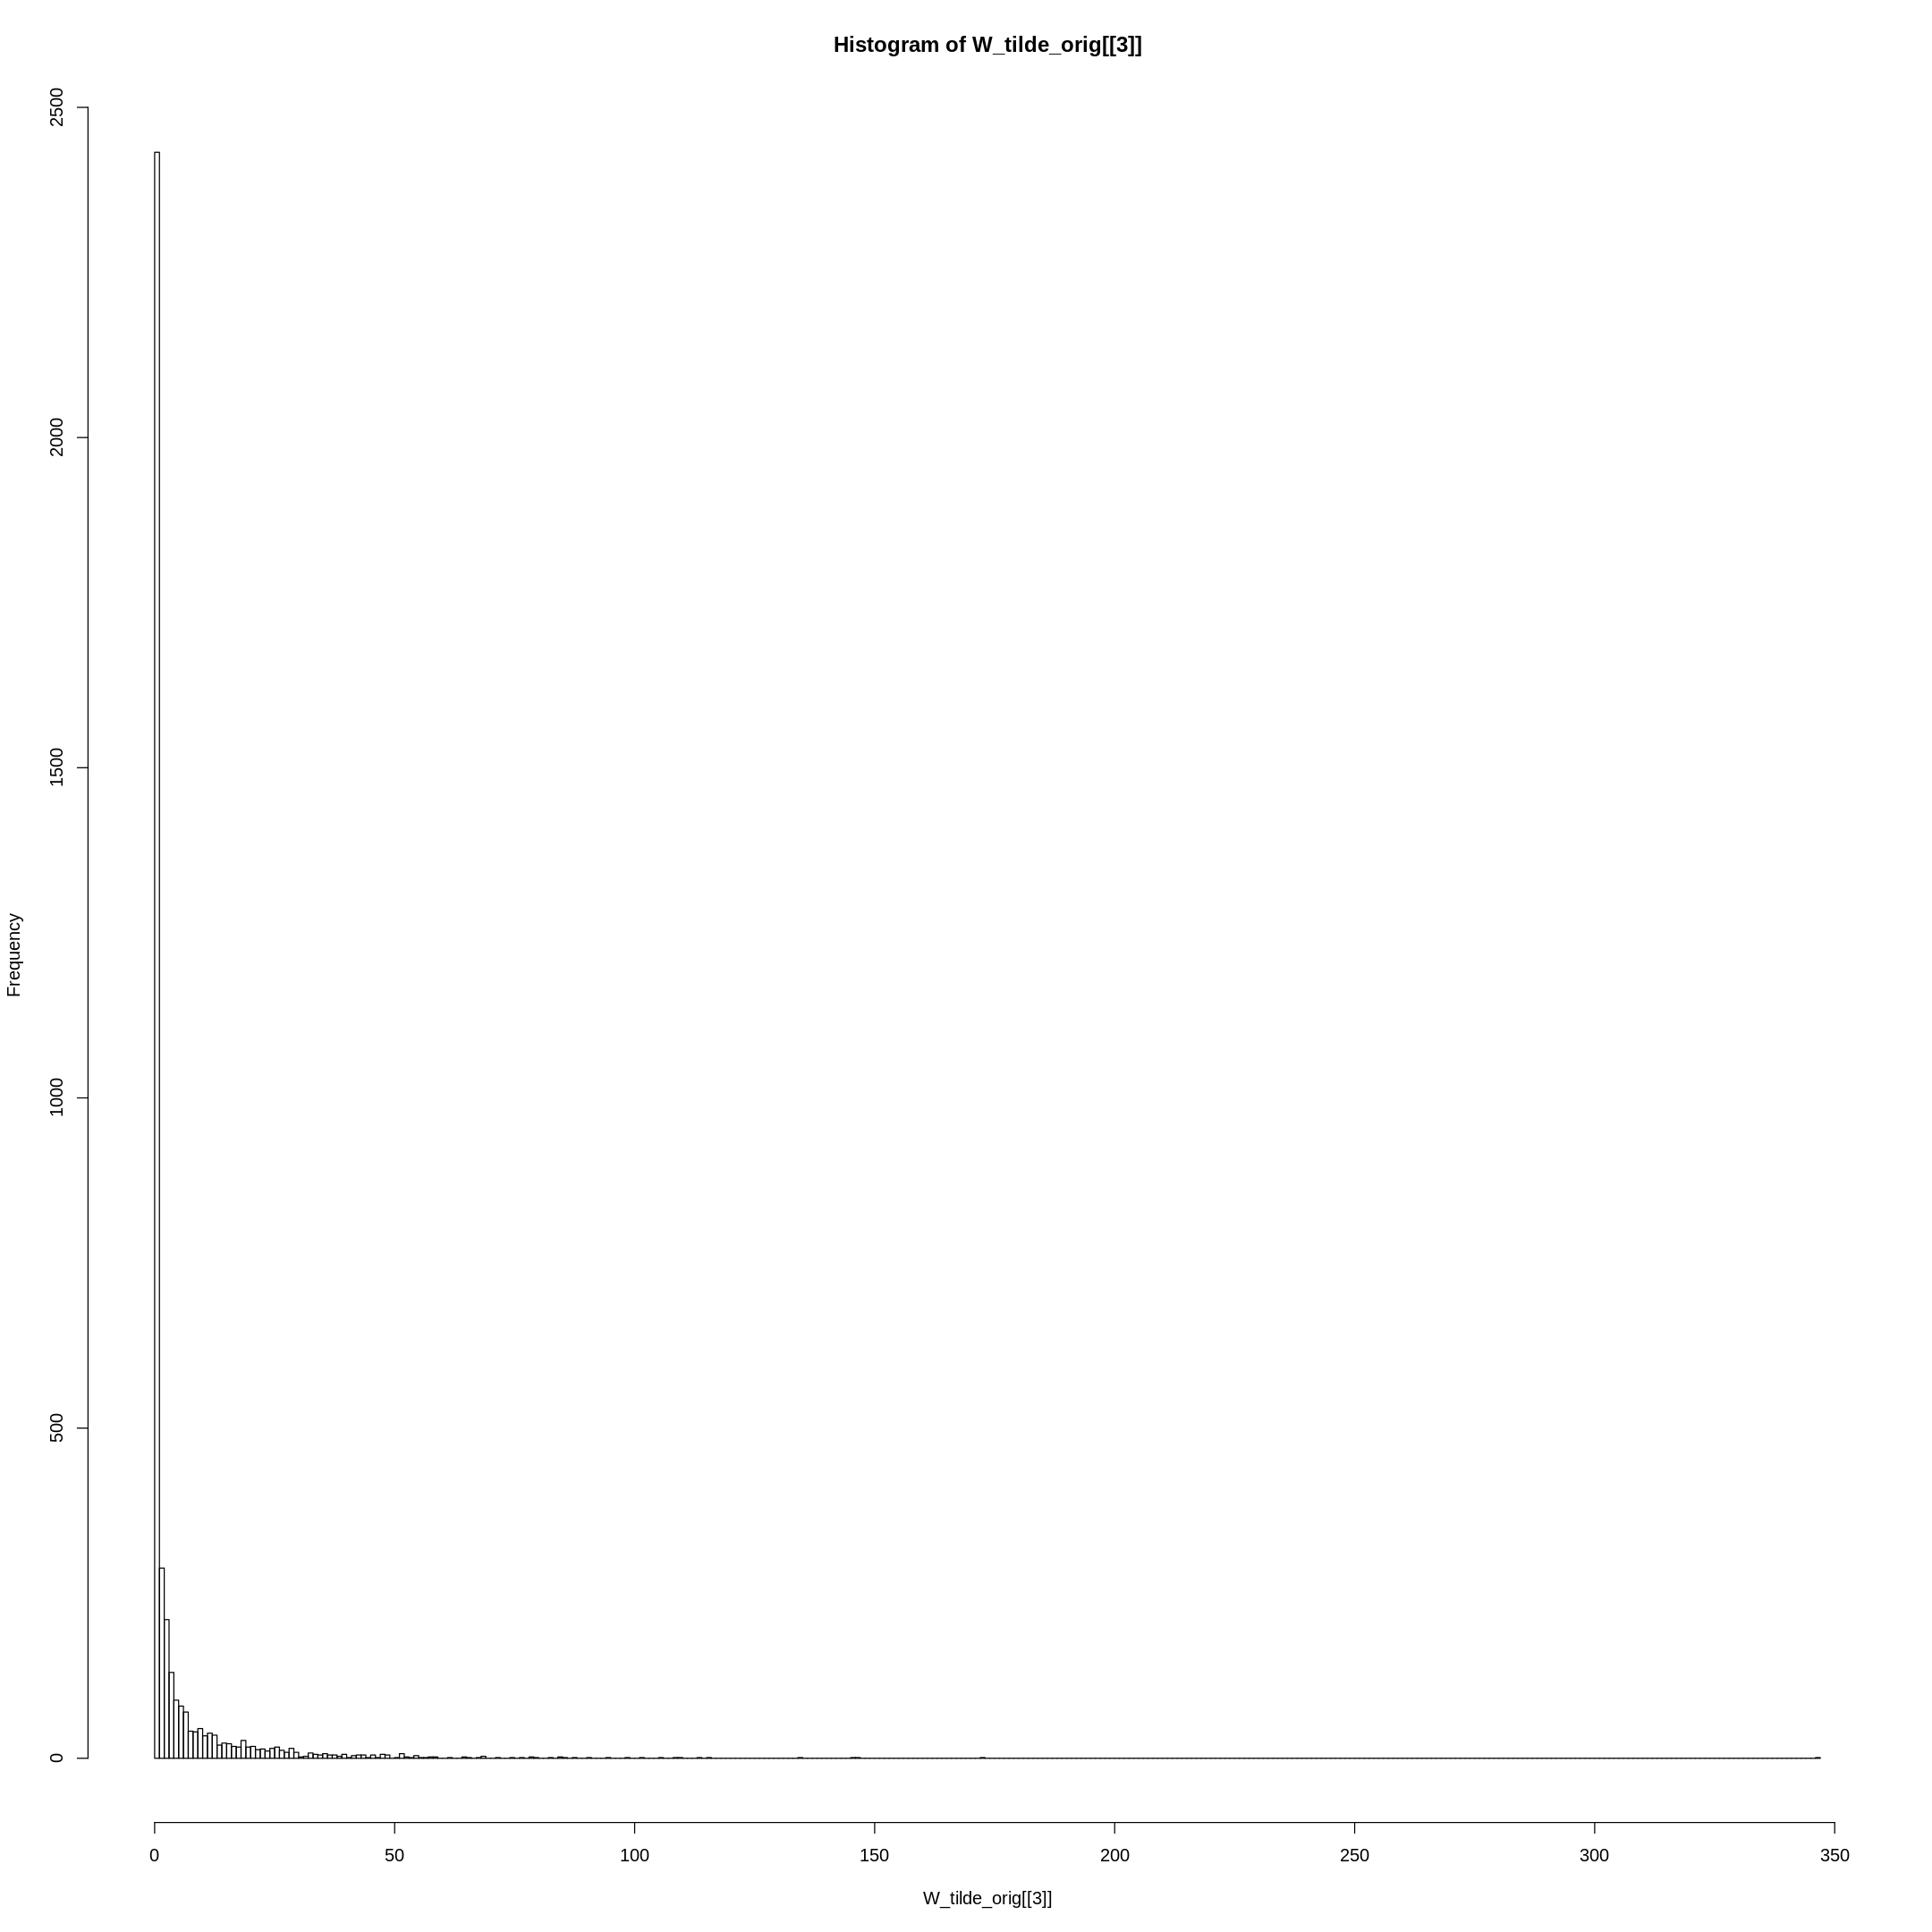

In [67]:
mean(1*(W_tilde_orig[[1]]>15))
hist(W_tilde_orig[[1]],300)
mean(1*(W_tilde_orig[[2]]>15))
hist(W_tilde_orig[[1]],300)
mean(1*(W_tilde_orig[[3]]>15))
hist(W_tilde_orig[[3]],300)

In [37]:
str(1*(W_tilde_orig[[5]]>1))

 num [1:16195, 1:3] 0 1 0 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:16195] "A1BG" "A2M" "A4GALT" "A4GNT" ...
  ..$ : chr [1:3] "T" "B" "NK cell"


In [ ]:
rst_list <- list()
rst_files = list.files(path = '/gpfs/ysm/pi/zhao-data/wd262/sc_immune/sc_immune/write/V2',pattern = "*_alpha1.rds", full.names = TRUE)
for(i in seq(length(rst_files))){
    
    rst <- readRDS(rst_files[i])
    rst_list[[i]] <- rst

}

In [23]:
mcmc_samples_theta1 = length(rst_list[[1]]$theta2$gamma)

get_est_vg <- function(j){
    est_vg <- lapply(c(1:mcmc_samples_theta1), function(i) rst_list[[j]]$theta2$gamma[[i]] * rst_list[[j]]$theta2$v[[i]])
    average_est_vg <- Reduce('+',est_vg)/mcmc_samples_theta1
    average_gamma_est <- Reduce('+',rst_list[[j]]$theta2$gamma)/mcmc_samples_theta1
    ans <- list()
    ans$vg <-  average_est_vg
    ans$averg_gamma <- average_gamma_est
    return(ans)                 
}

                     

In [24]:
gamma_list <- lapply(c(1:5), function(j) get_est_vg(j)$averg_gamma)
est_vg_list <- lapply(c(1:5), function(j) get_est_vg(j)$vg)


In [29]:
str(W_tilde_orig[[1]])
str(gamma_list[[1]])
str(rst_list[[1]])

 num [1:986, 1:4] 9.617 6.701 0.735 4.367 3.846 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:986] "ACTB" "ACTG1" "AGTRAP" "AIF1" ...
  ..$ : chr [1:4] "B" "T" "Monocyte" "NK cell"
 num [1:986, 1:4] 0.6 0.98 0 0 0 0 0 0 0 0.44 ...
List of 2
 $ theta1:List of 1
  ..$ w:List of 4
  .. ..$ : num [1:986, 1:4] 1.2236 0.6964 0.0528 0.2234 0.1878 ...
  .. ..$ : num [1:986, 1:4] 0.5316 0.9043 0.0417 0.1752 0.4311 ...
  .. ..$ : num [1:986, 1:4] 0.8622 0.8029 0.0682 0.5611 0.3917 ...
  .. ..$ : num [1:986, 1:4] 1.6355 1.9493 0.0762 0.3176 0.3665 ...
 $ theta2:List of 9
  ..$ alpha_unif   : num [1:1276, 1] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ gamma        :List of 50
  .. ..$ : num [1:986, 1:4] 1 1 0 0 0 0 0 0 0 0 ...
  .. ..$ : num [1:986, 1:4] 1 1 0 0 0 0 0 0 0 0 ...
  .. ..$ : num [1:986, 1:4] 1 1 0 0 0 0 0 0 0 0 ...
  .. ..$ : num [1:986, 1:4] 1 1 0 0 0 0 0 0 0 0 ...
  .. ..$ : num [1:986, 1:4] 0 1 0 0 0 0 0 0 0 0 ...
  .. ..$ : num [1:986, 1:4] 0 1 0 0 0 0 0 0 0 0 ...
  .. ..$ : num [1:986, 

In [16]:
tissue_list[c(6,5,2,1)]

[1] "PBMC" "Lung" "CB"   "BM"

In [53]:
sapply(gamma_list,mean)

[1] 0.1060700 0.1128600 0.1152079 0.1210751 0.1285649

In [70]:
tbl <- lapply(c(1:5),function(idx) 
    data.frame('Estmated_Gamma' = as.vector(gamma_list[[idx]]),
               "True_Gamma" = as.vector(1*(W_tilde_orig[[1]]>15)),
               "initial_pi" = rep(0.05*(idx+1),length(as.vector(gamma_list[[idx]])))))
tbl <- Reduce(rbind, tbl)

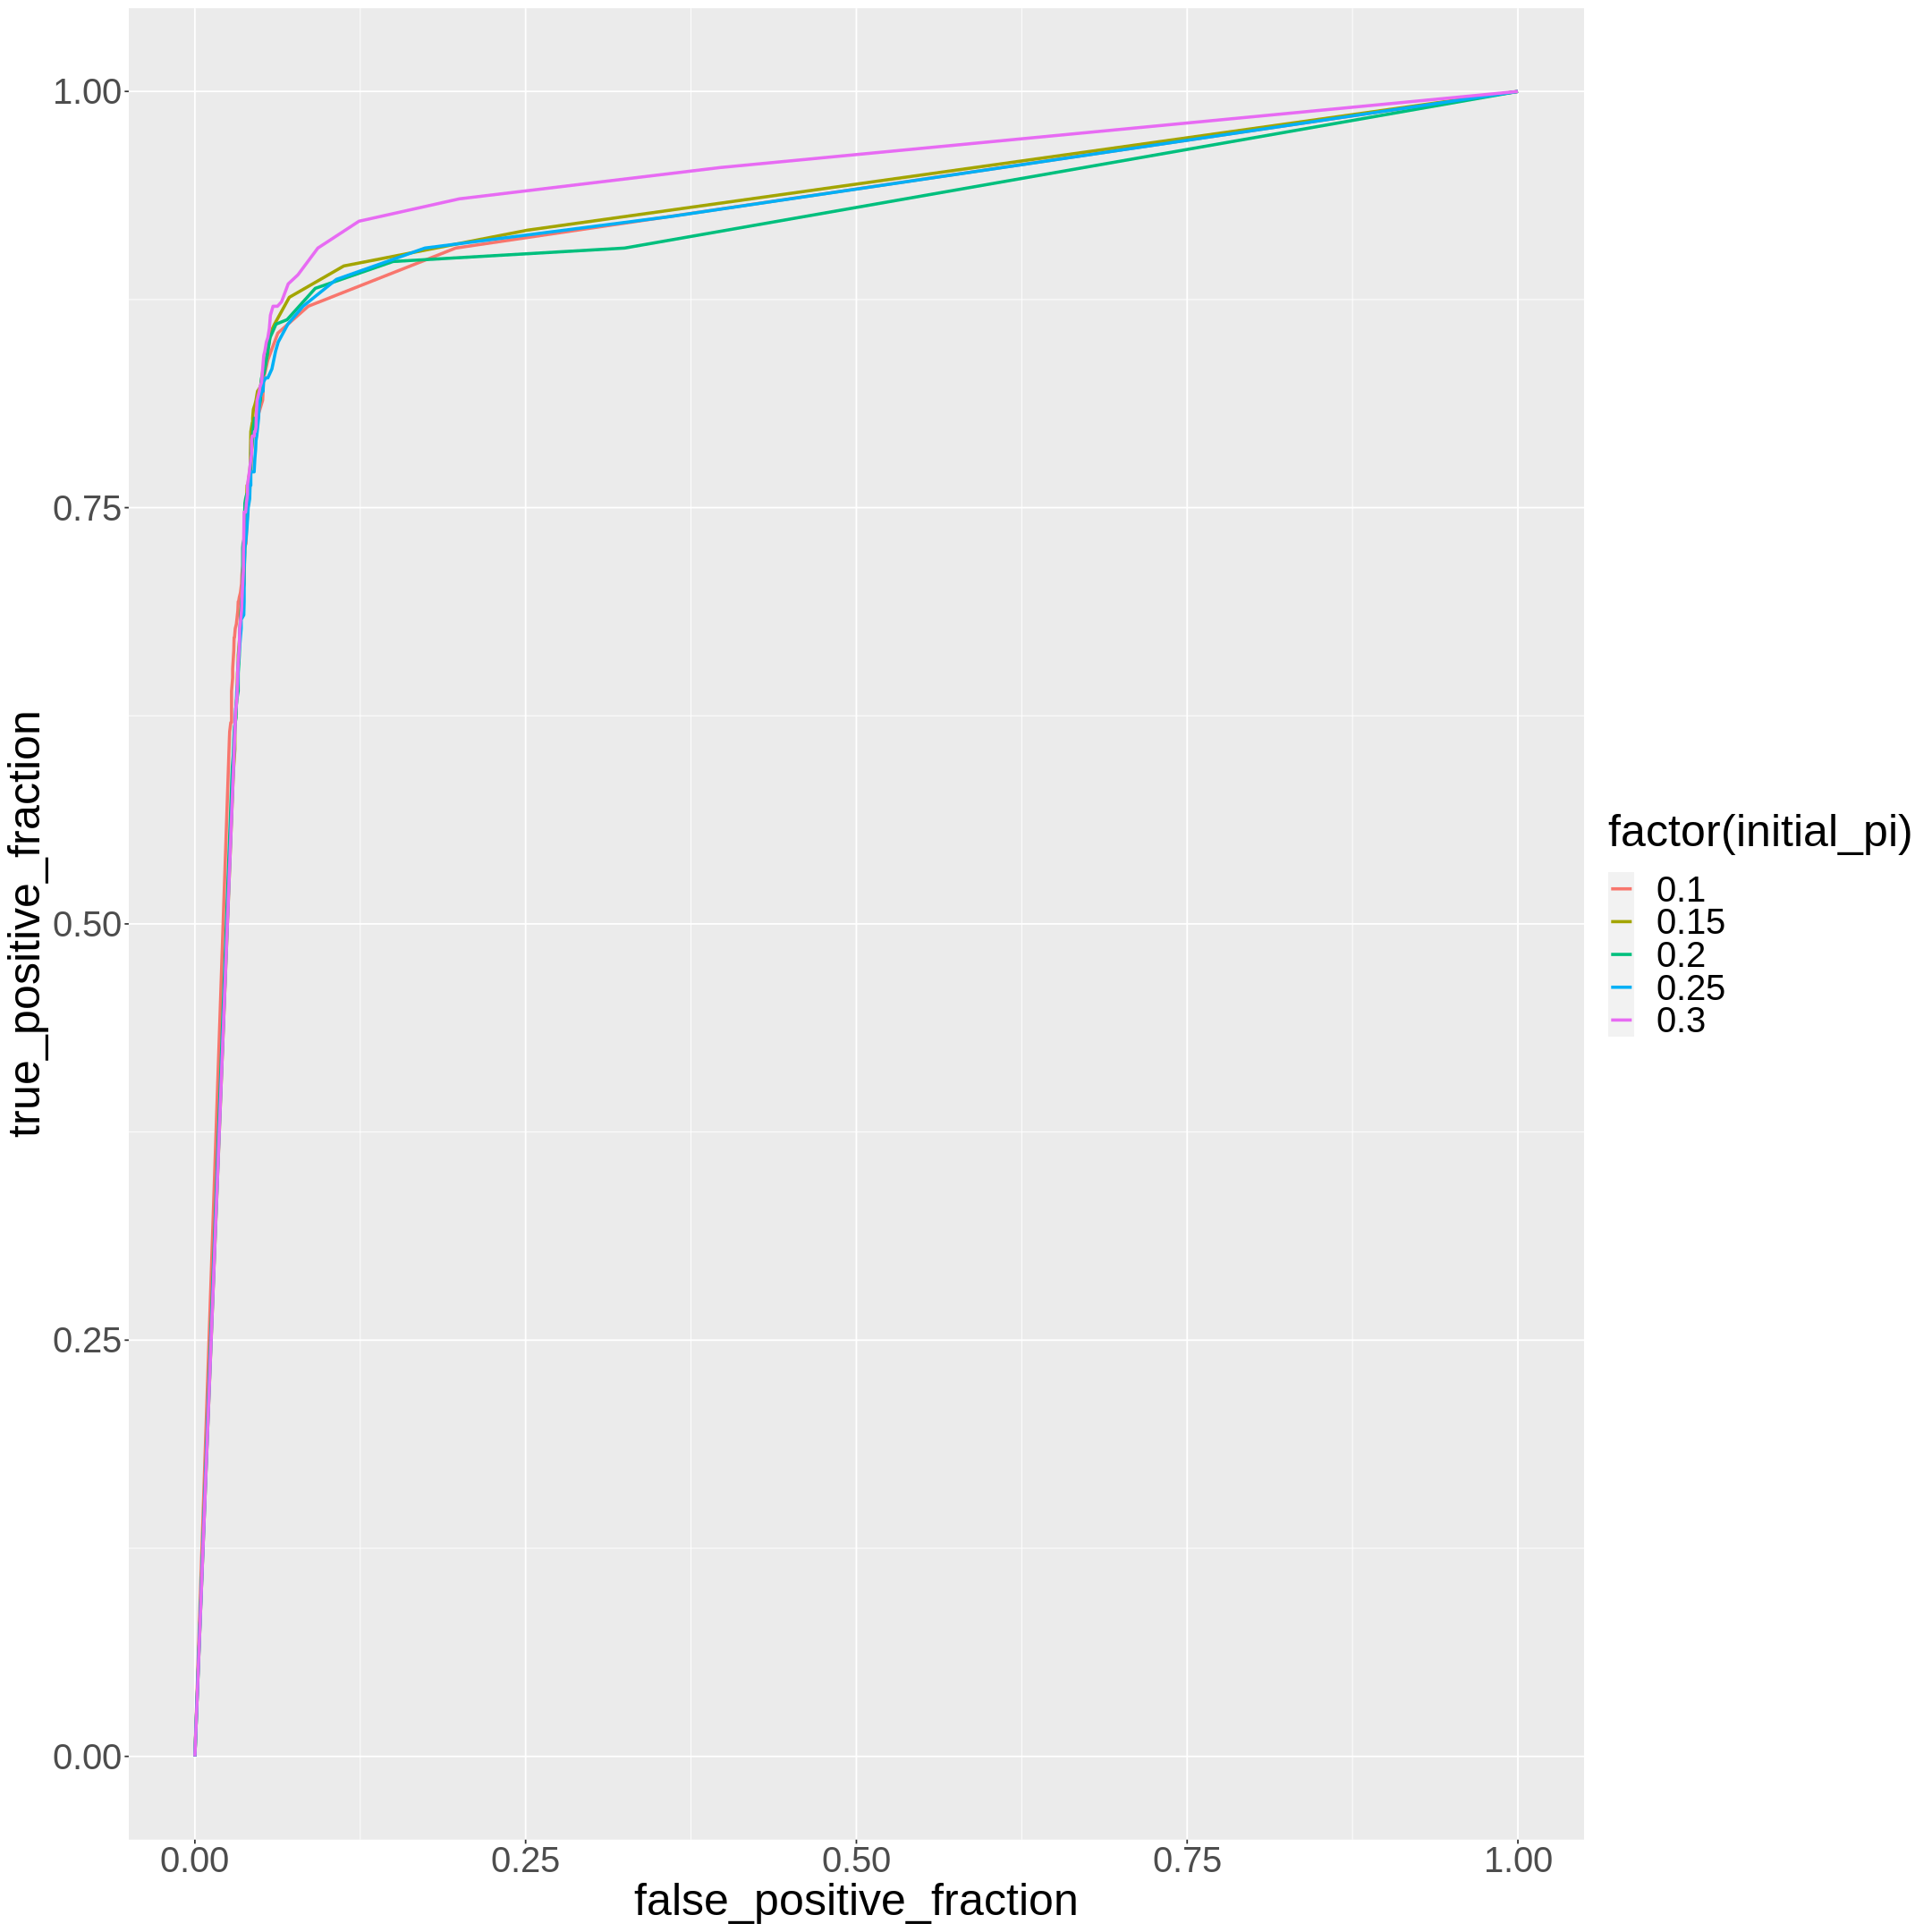

In [71]:
ggplot(tbl, aes(d=True_Gamma,m=Estmated_Gamma,color=factor(initial_pi)))+geom_roc(n.cuts = 0)+theme(text = element_text(size = 30))  

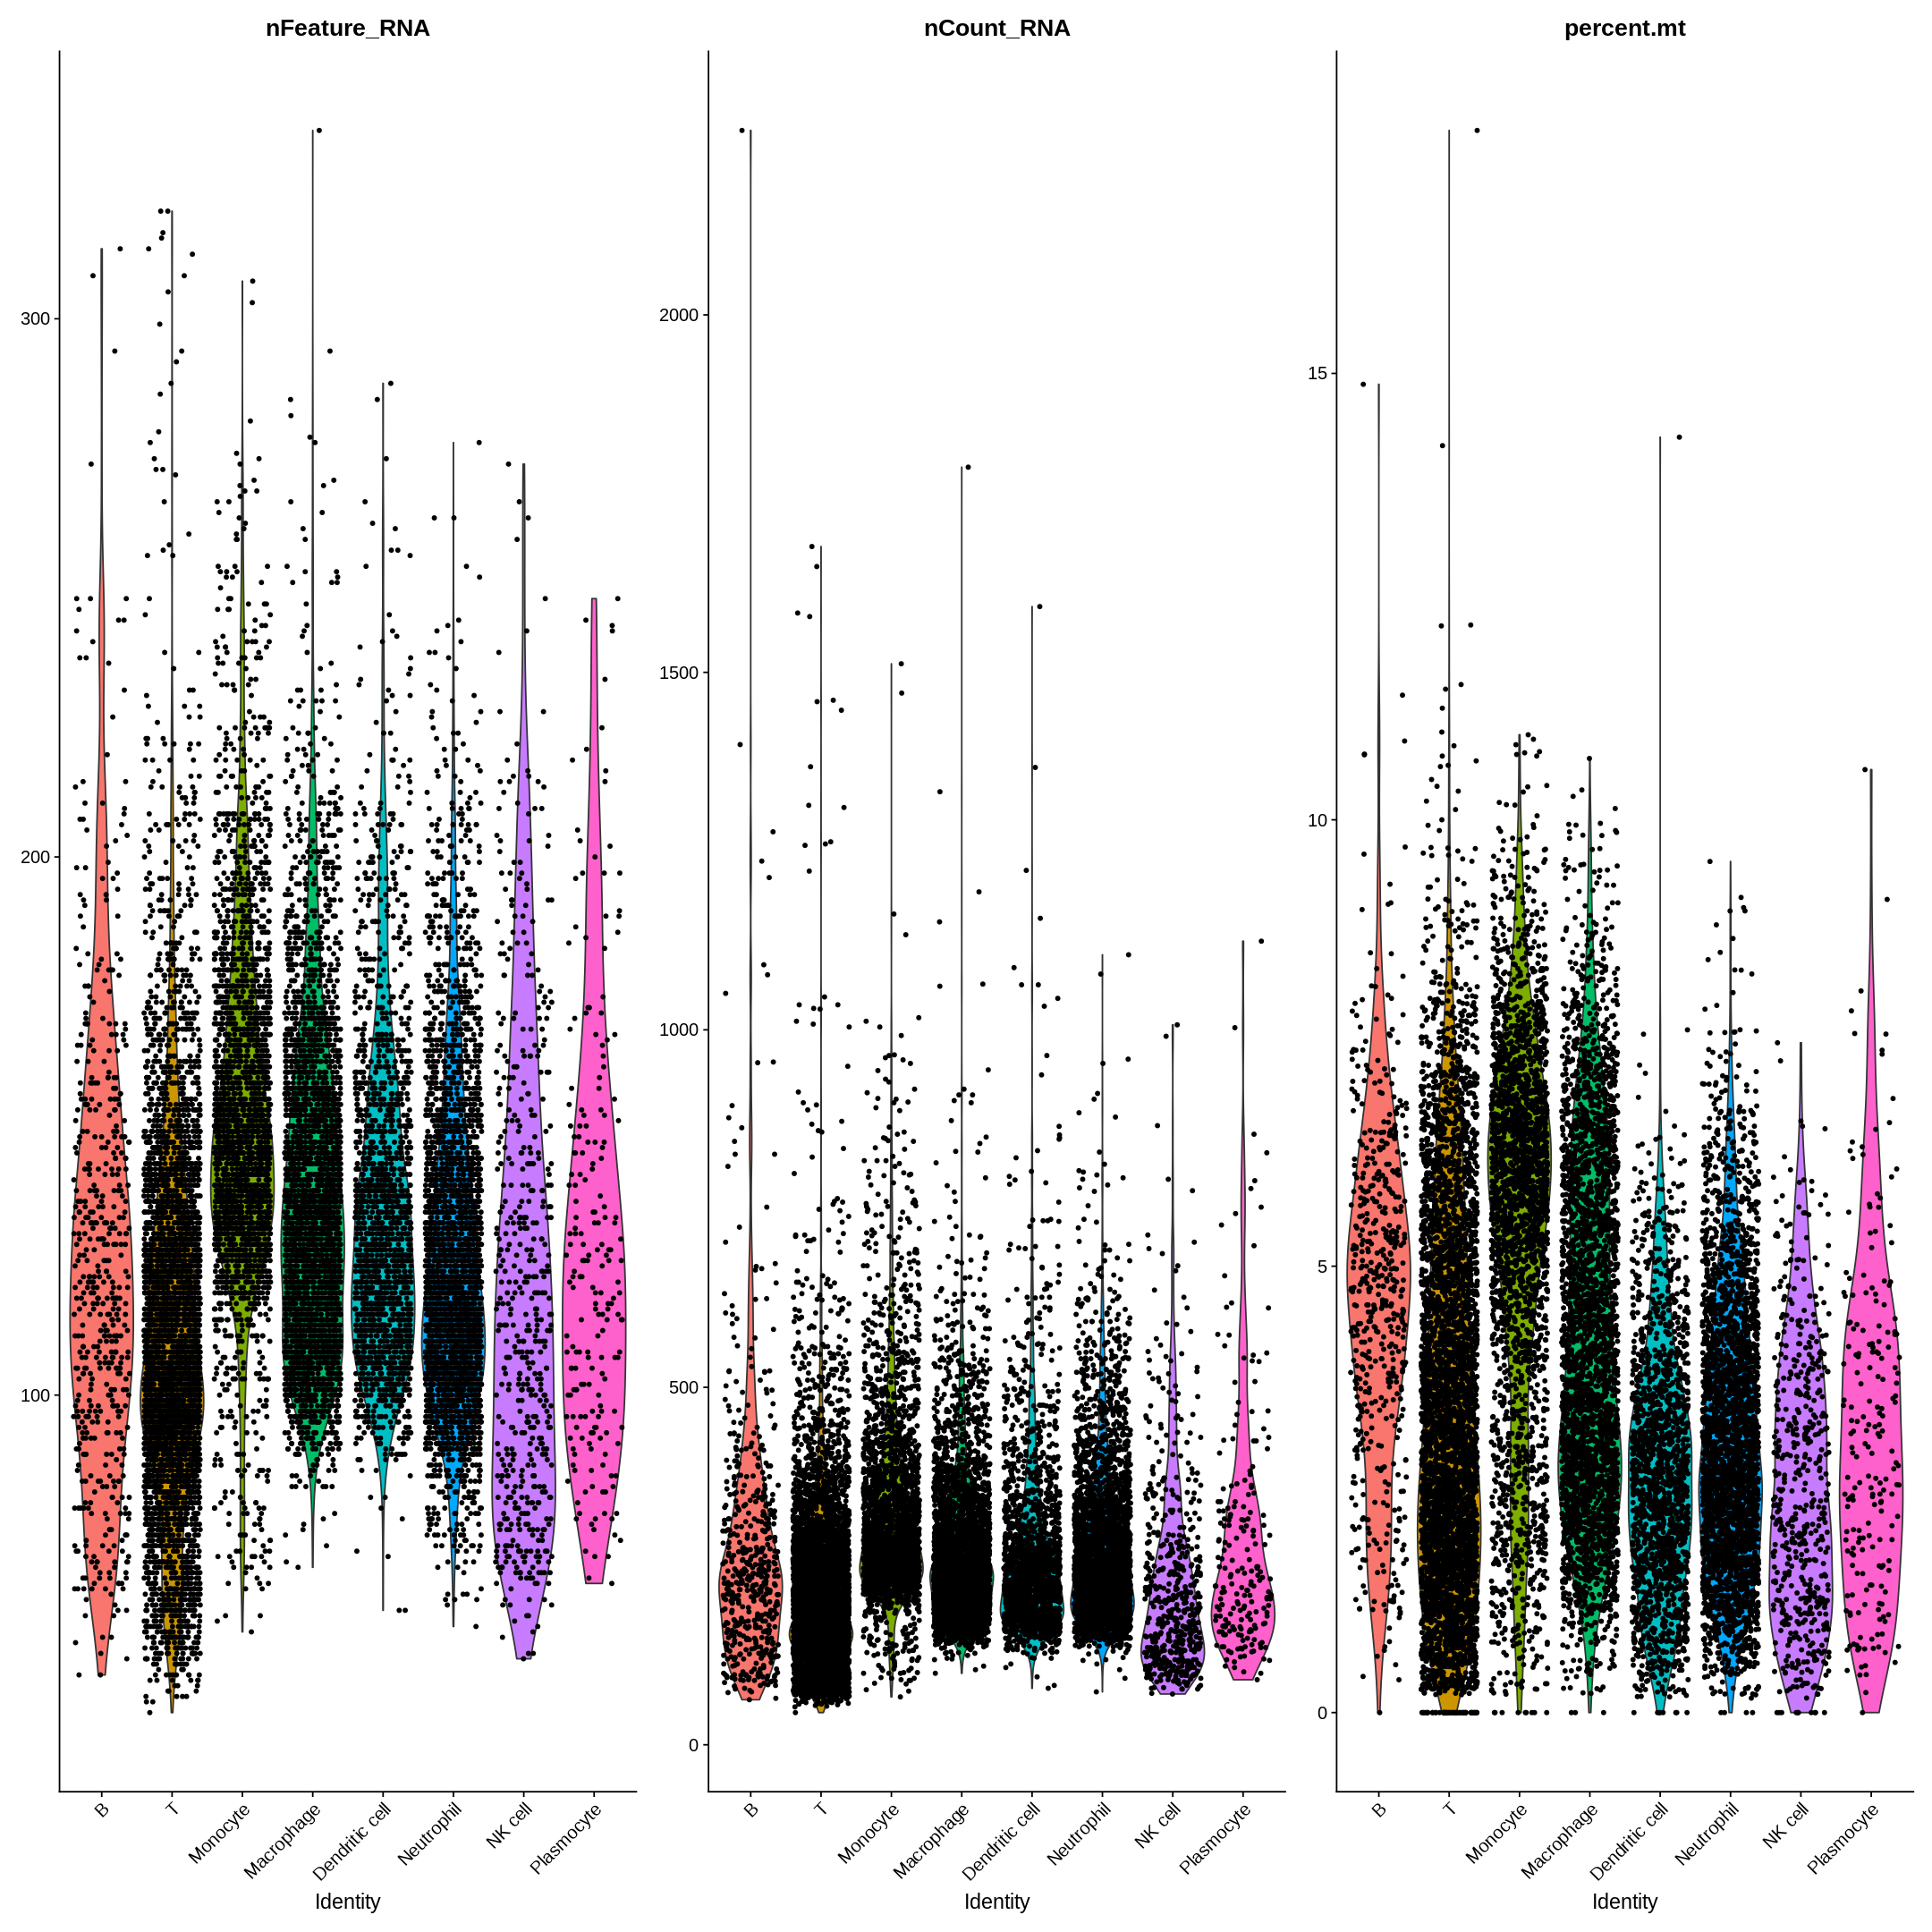

In [57]:
VlnPlot(subset(seur_list[[6]],features=YSG), features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [58]:
subset(seur_list[[6]],features=YSG)

An object of class Seurat 
1035 features across 16559 samples within 1 assay 
Active assay: RNA (1035 features, 349 variable features)
 2 dimensional reductions calculated: pca, umap

orig.ident      nCount_RNA nFeature_RNA
PeripheralBlood_1.GGCTGCATCTCTATTTGC PeripheralBlood 2258       308         
PeripheralBlood_1.TCGGGTGAGATCACAATA PeripheralBlood  826       237         
PeripheralBlood_1.CTGTGTGTATACCAACAA PeripheralBlood 1368       315         
PeripheralBlood_1.AAGCGGTTGGACTAGAGA PeripheralBlood 1512       303         
PeripheralBlood_1.CTCCATCGTGGCCTTCTG PeripheralBlood 1583       313         
PeripheralBlood_1.CTCGCAACCTGATCTACC PeripheralBlood 1459       305         
                                     Cell_barcode       Sample         
PeripheralBlood_1.GGCTGCATCTCTATTTGC GGCTGCATCTCTATTTGC PeripheralBlood
PeripheralBlood_1.TCGGGTGAGATCACAATA TCGGGTGAGATCACAATA PeripheralBlood
PeripheralBlood_1.CTGTGTGTATACCAACAA CTGTGTGTATACCAACAA PeripheralBlood
PeripheralBlood_1.AAGCGGTTGGACTAGAGA AAGCGGTTGGACTAGAGA PeripheralBlood
PeripheralBlood_1.CTCCATCGTGGCCTTCTG CTCCATCGTGGCCTTCTG PeripheralBlood
PeripheralBlood_1.CTCGCAACCTGATCTACC CTCGCAACCTGATCTACC PeripheralBlood
                                     Batch           
PeripheralBlood_1.GGCTGCATCTCTATTTGC PeripheralBlood1
PeripheralBlood_1.TCGGGTGAGATCACAATA PeripheralBlood1
PeripheralBlood_1.CTGTGTGTATACCAACAA PeripheralBlood1
PeripheralBlood_1.AAGCGGTTGGACTAGAGA PeripheralBlood1
PeripheralBlood_1.CTCCATCGTGGCCTTCTG PeripheralBlood1
PeripheralBlood_1.CTCGCAACCTGATCTACC PeripheralBlood1
                                     Cell_id                             
PeripheralBlood_1.GGCTGCATCTCTATTTGC PeripheralBlood_1.GGCTGCATCTCTATTTGC
PeripheralBlood_1.TCGGGTGAGATCACAATA PeripheralBlood_1.TCGGGTGAGATCACAATA
PeripheralBlood_1.CTGTGTGTATACCAACAA PeripheralBlood_1.CTGTGTGTATACCAACAA
PeripheralBlood_1.AAGCGGTTGGACTAGAGA PeripheralBlood_1.AAGCGGTTGGACTAGAGA
PeripheralBlood_1.CTCCATCGTGGCCTTCTG PeripheralBlood_1.CTCCATCGTGGCCTTCTG
PeripheralBlood_1.CTCGCAACCTGATCTACC PeripheralBlood_1.CTCGCAACCTGATCTACC
                                     Cluster_id               Ages
PeripheralBlood_1.GGCTGCATCTCTATTTGC AdultPeripheralBlood1_10 34Y 
PeripheralBlood_1.TCGGGTGAGATCACAATA AdultPeripheralBlood1_5  34Y 
PeripheralBlood_1.CTGTGTGTATACCAACAA AdultPeripheralBlood1_1  34Y 
PeripheralBlood_1.AAGCGGTTGGACTAGAGA AdultPeripheralBlood1_2  34Y 
PeripheralBlood_1.CTCCATCGTGGCCTTCTG AdultPeripheralBlood1_1  34Y 
PeripheralBlood_1.CTCGCAACCTGATCTACC AdultPeripheralBlood1_1  34Y 
                                     Development_stage ⋯ Gender Source
PeripheralBlood_1.GGCTGCATCTCTATTTGC Adult             ⋯ Male   HCL   
PeripheralBlood_1.TCGGGTGAGATCACAATA Adult             ⋯ Male   HCL   
PeripheralBlood_1.CTGTGTGTATACCAACAA Adult             ⋯ Male   HCL   
PeripheralBlood_1.AAGCGGTTGGACTAGAGA Adult             ⋯ Male   HCL   
PeripheralBlood_1.CTCCATCGTGGCCTTCTG Adult             ⋯ Male   HCL   
PeripheralBlood_1.CTCGCAACCTGATCTACC Adult             ⋯ Male   HCL   
                                     Biomaterial         
PeripheralBlood_1.GGCTGCATCTCTATTTGC AdultPeripheralBlood
PeripheralBlood_1.TCGGGTGAGATCACAATA AdultPeripheralBlood
PeripheralBlood_1.CTGTGTGTATACCAACAA AdultPeripheralBlood
PeripheralBlood_1.AAGCGGTTGGACTAGAGA AdultPeripheralBlood
PeripheralBlood_1.CTCCATCGTGGCCTTCTG AdultPeripheralBlood
PeripheralBlood_1.CTCGCAACCTGATCTACC AdultPeripheralBlood
                                     Name                      ident
PeripheralBlood_1.GGCTGCATCTCTATTTGC AdultPeripheralBlood1_34Y 10   
PeripheralBlood_1.TCGGGTGAGATCACAATA AdultPeripheralBlood1_34Y  5   
PeripheralBlood_1.CTGTGTGTATACCAACAA AdultPeripheralBlood1_34Y  1   
PeripheralBlood_1.AAGCGGTTGGACTAGAGA AdultPeripheralBlood1_34Y  2   
PeripheralBlood_1.CTCCATCGTGGCCTTCTG AdultPeripheralBlood1_34Y  1   
PeripheralBlood_1.CTCGCAACCTGATCTACC AdultPeripheralBlood1_34Y  1   
                                     Celltype              Celltype_NA
PeripheralBlood_1.GGCTGCATCTCTATTTGC Proliferating  B cell FALSE      
PeripheralBlood_1.TCGGGTGAGATCACAATA B cell                FALSE      
PeripheralBlood_1.CTGTGTGTATAC

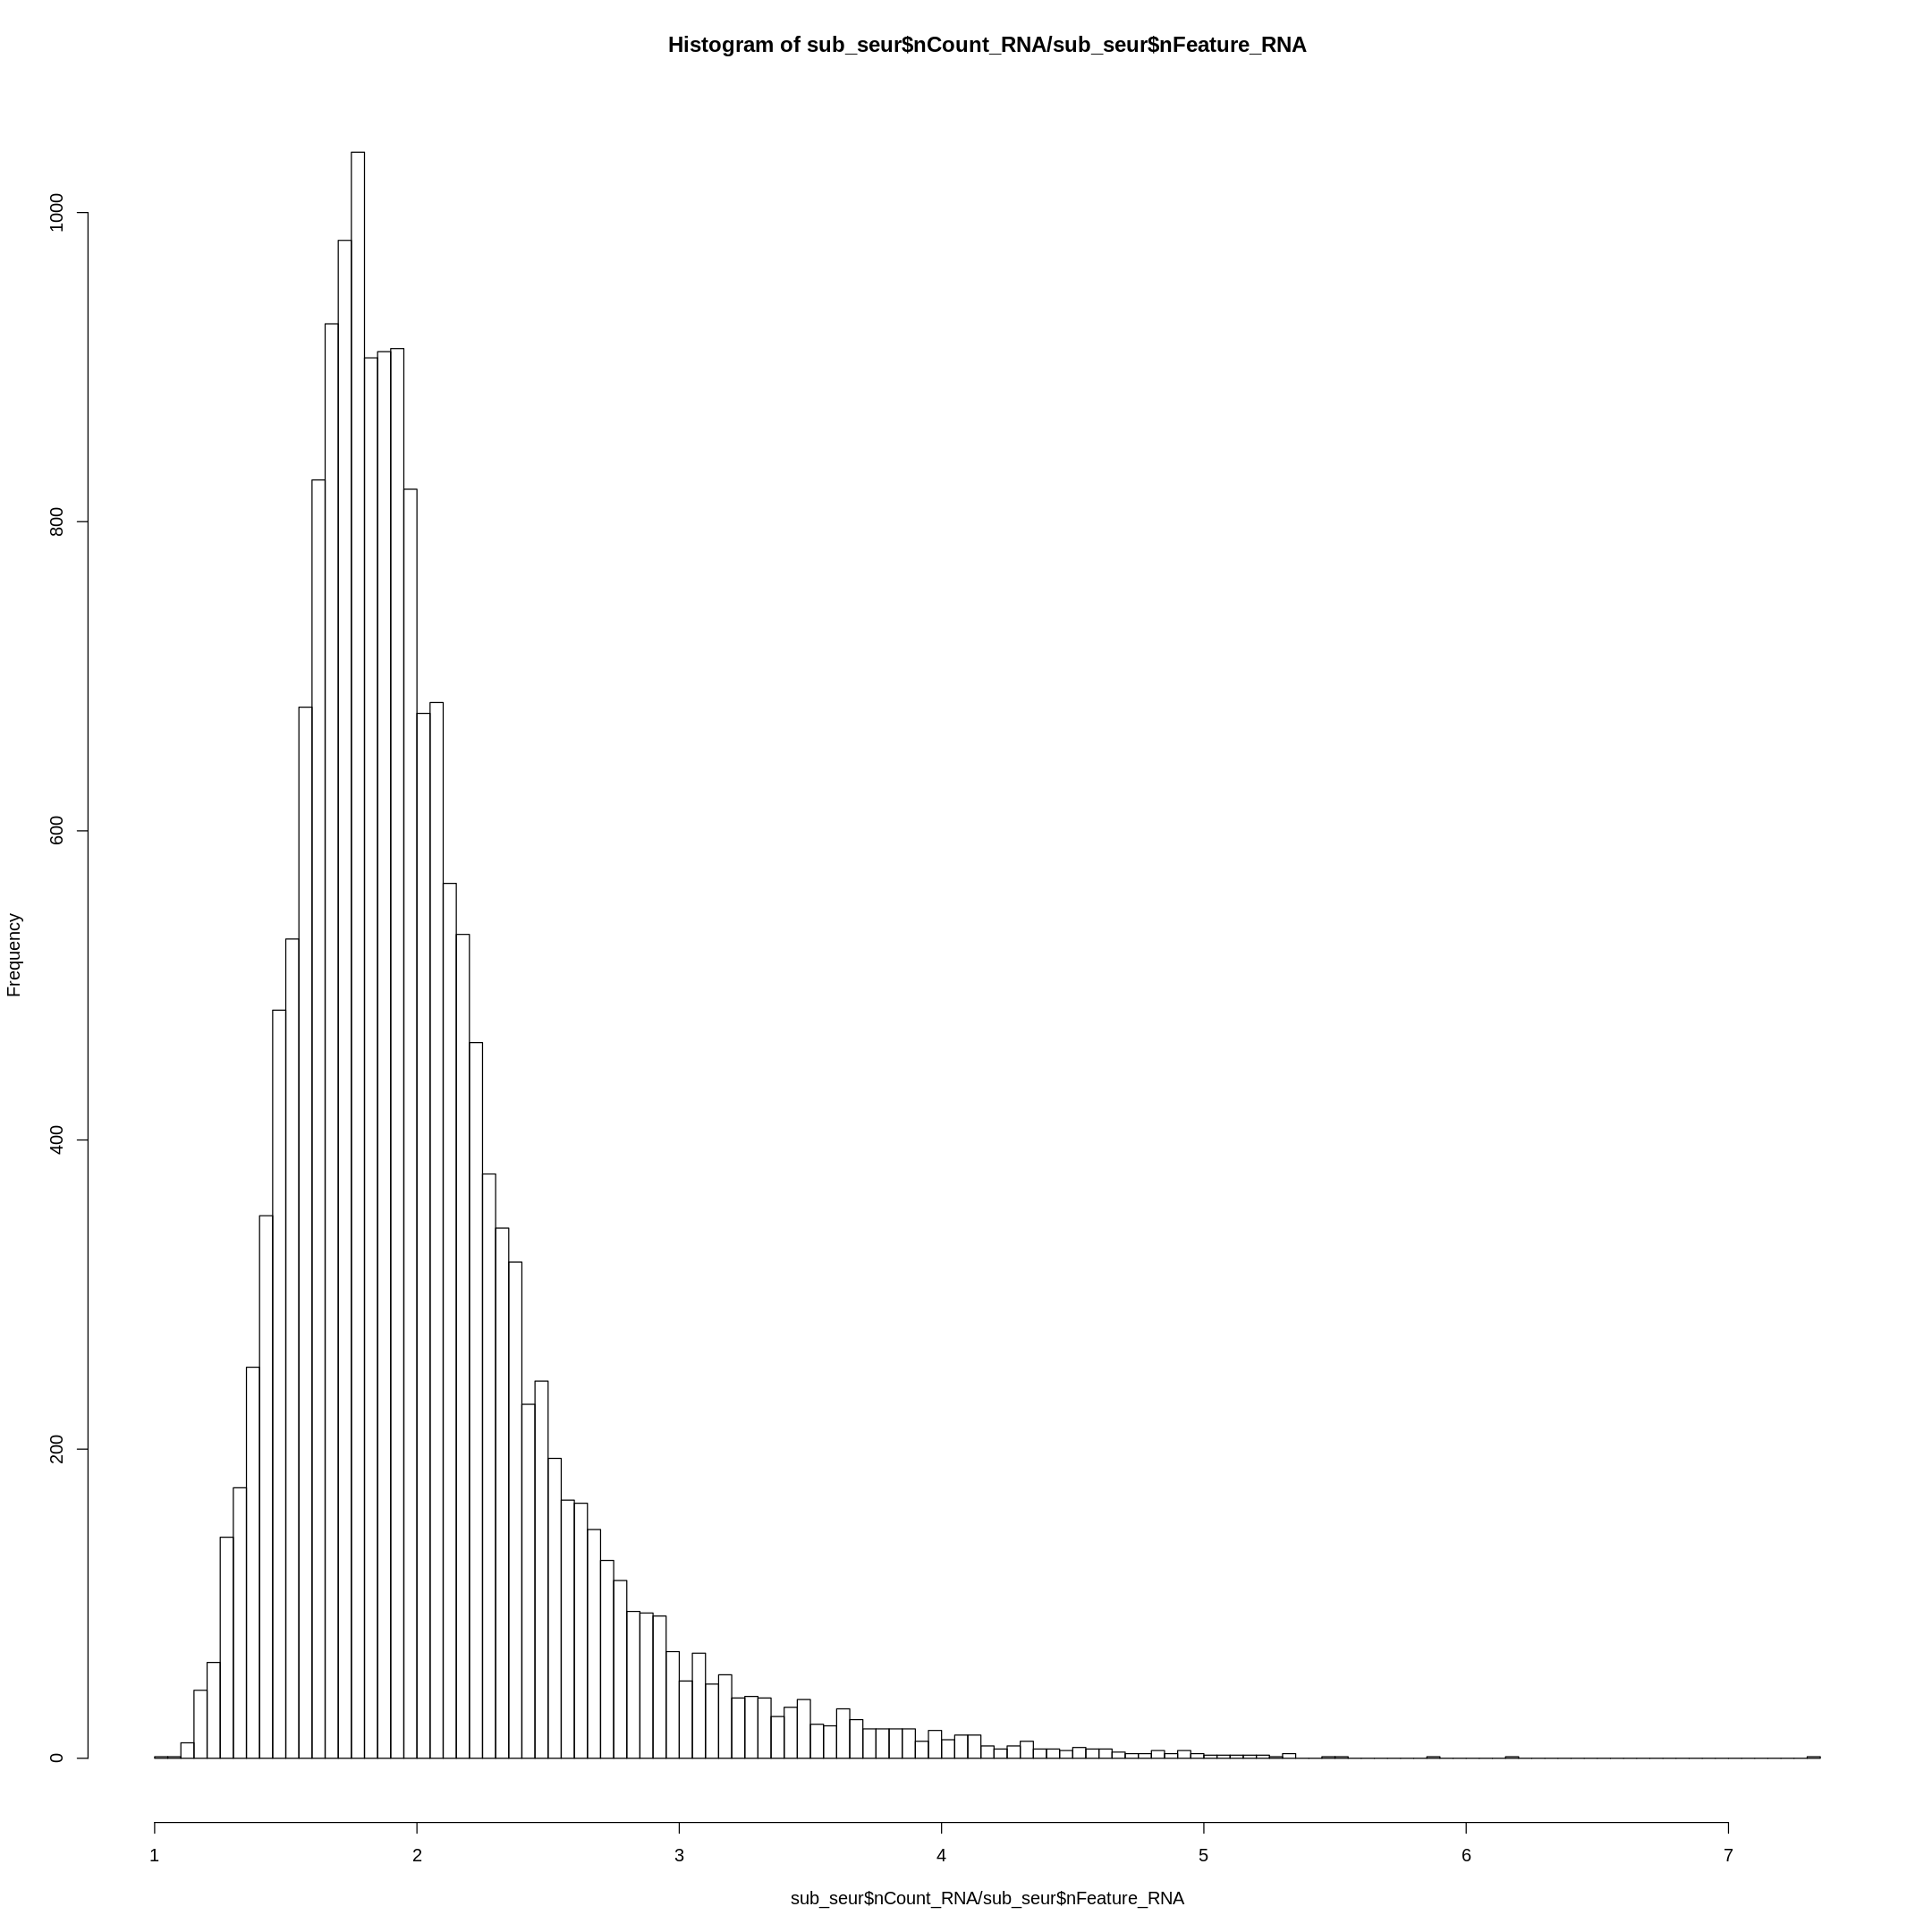

[1] 0.1245607

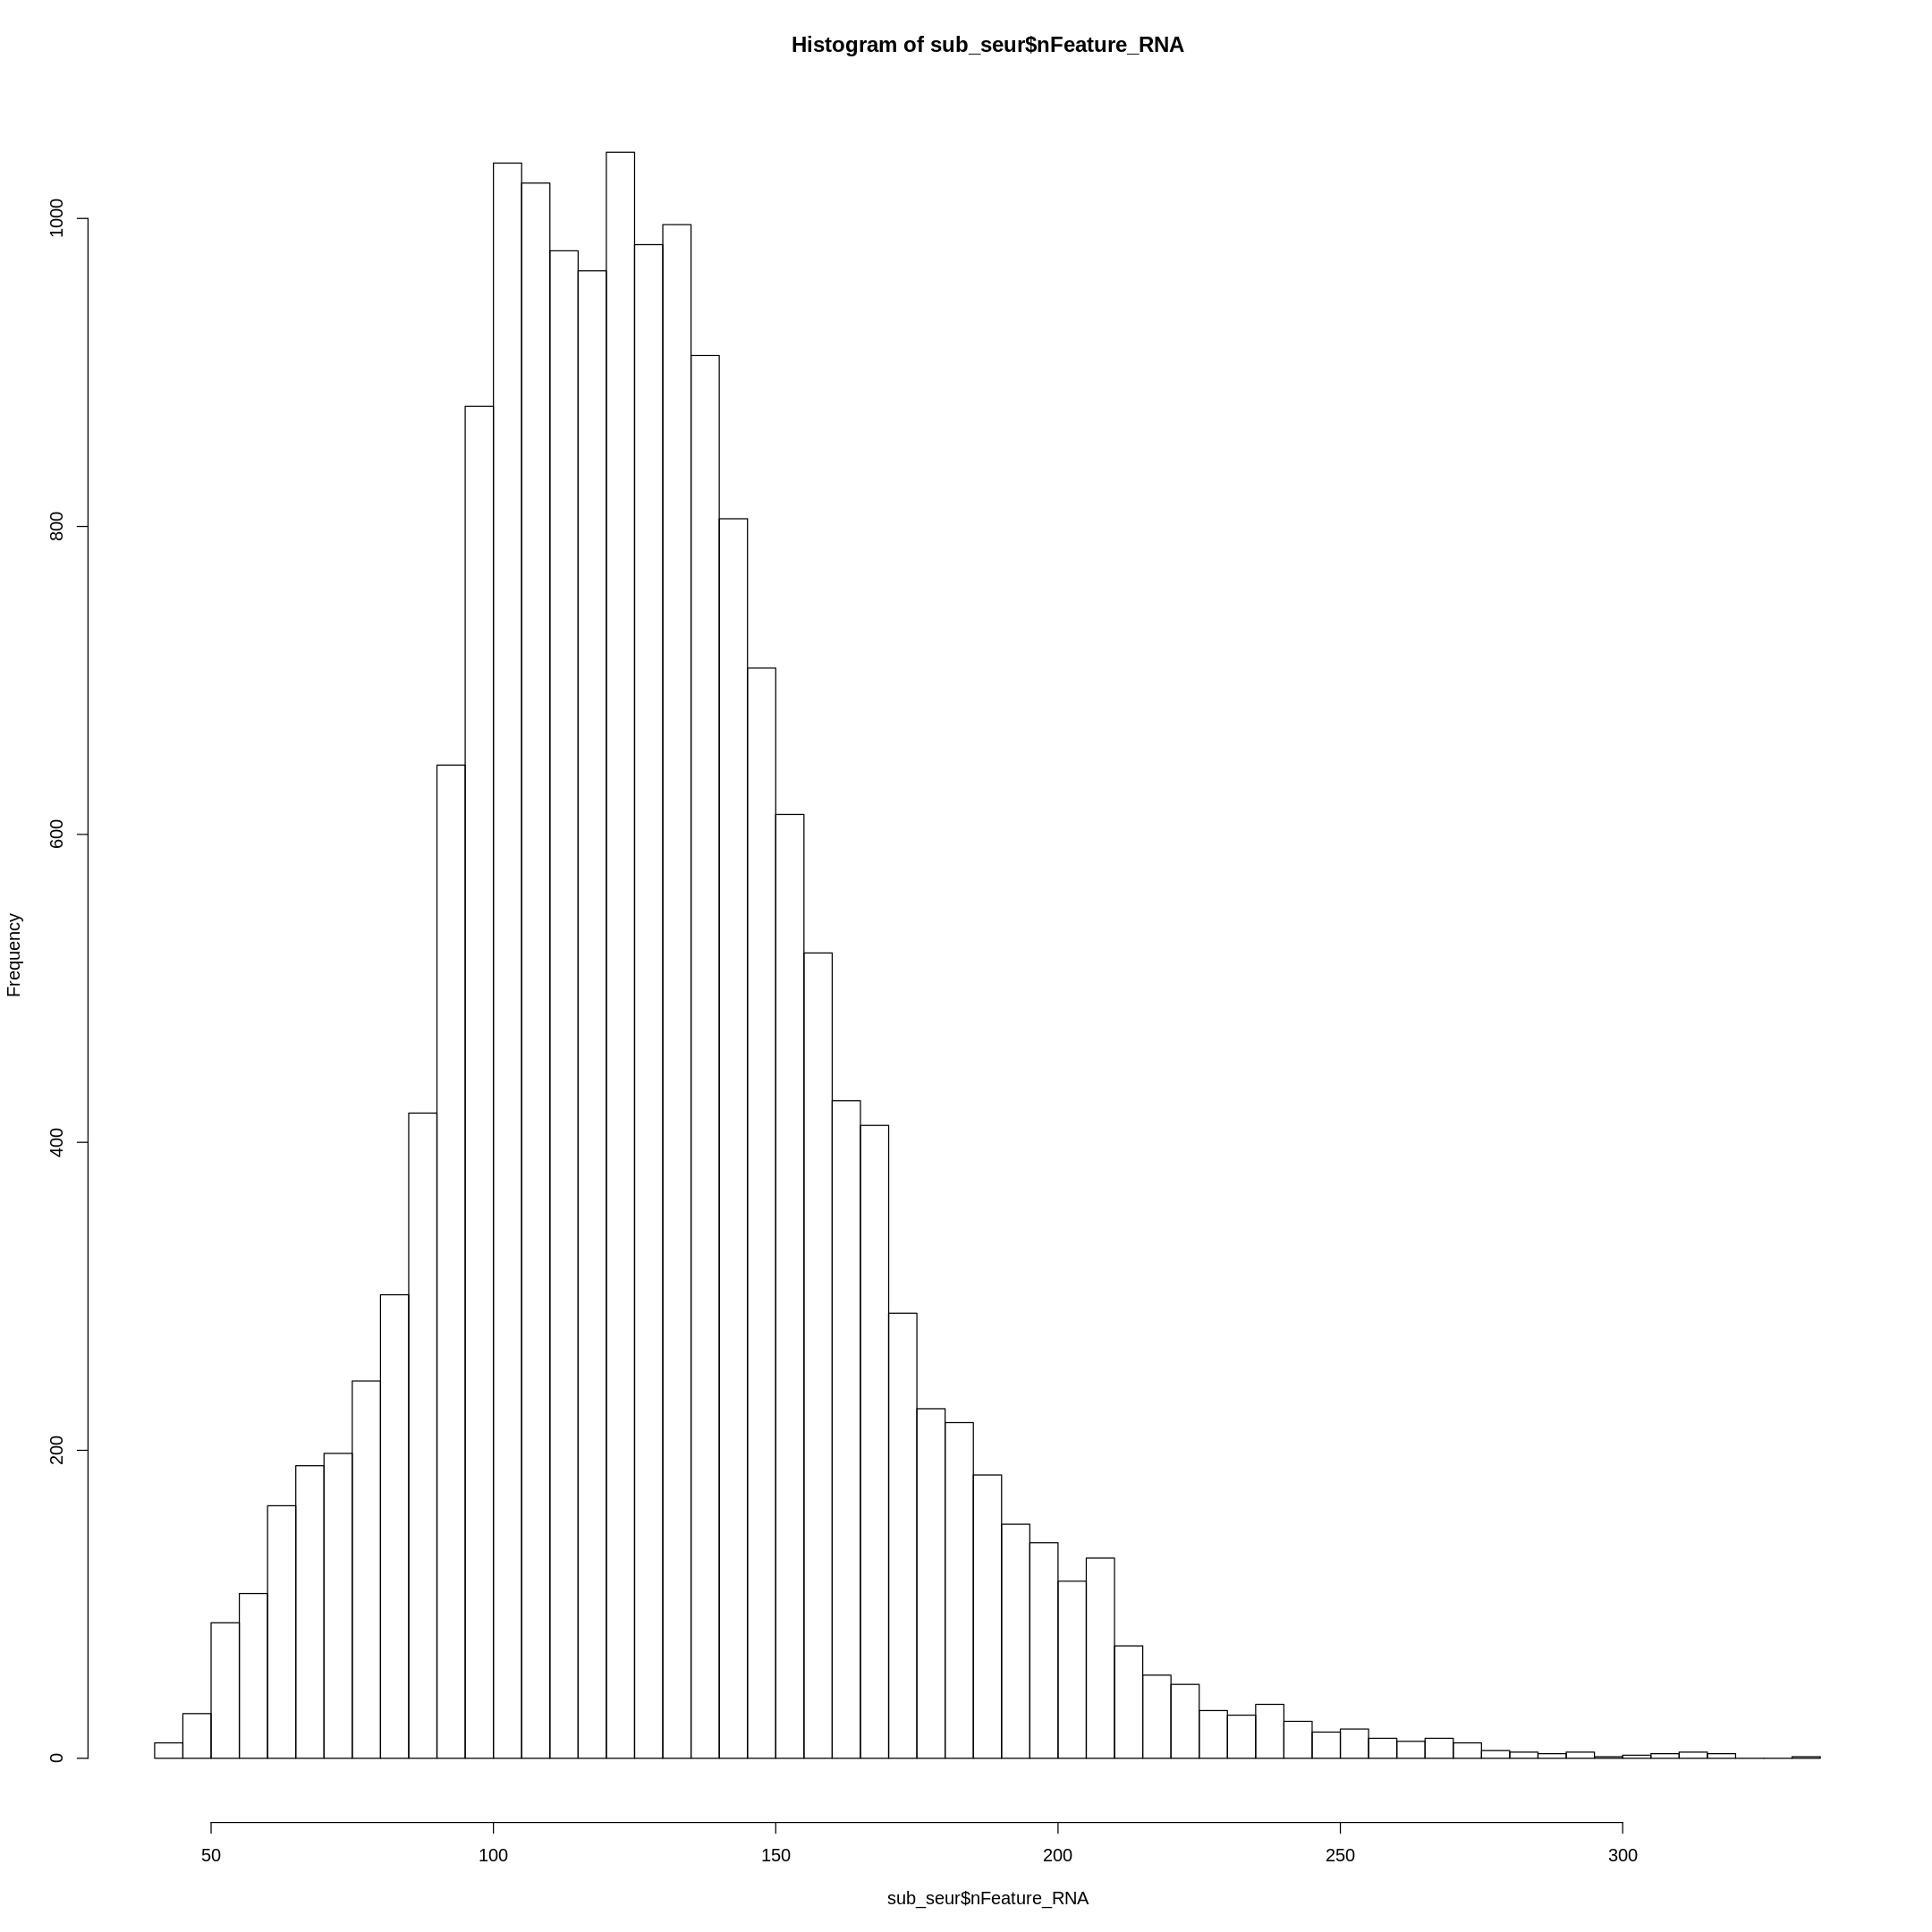

In [65]:
sub_seur <- subset(seur_list[[6]],features=YSG)
head(sub_seur@meta.data)
hist(sub_seur$nCount_RNA/sub_seur$nFeature_RNA,100)
hist(sub_seur$nFeature_RNA,100)
mean(sub_seur$nFeature_RNA/nrow(sub_seur))

orig.ident     nCount_RNA nFeature_RNA
CordBloodCD34P_1.CTGTGTATCTCTGTAATG CordBloodCD34P 1729       238         
CordBloodCD34P_1.CTGTGTGCAGGATGTGCG CordBloodCD34P 1538       235         
CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA CordBloodCD34P 1332       228         
CordBloodCD34P_1.CTGTGTAACCTAAAGCGG CordBloodCD34P 1195       195         
CordBloodCD34P_1.TTCATAGTATACTACTTC CordBloodCD34P 1201       203         
CordBloodCD34P_1.GGACATATCTCTGATCTT CordBloodCD34P 1138       195         
                                    Cell_barcode       Sample        
CordBloodCD34P_1.CTGTGTATCTCTGTAATG CTGTGTATCTCTGTAATG CordBloodCD34P
CordBloodCD34P_1.CTGTGTGCAGGATGTGCG CTGTGTGCAGGATGTGCG CordBloodCD34P
CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA CTGTGTGTCGGTCCGCTA CordBloodCD34P
CordBloodCD34P_1.CTGTGTAACCTAAAGCGG CTGTGTAACCTAAAGCGG CordBloodCD34P
CordBloodCD34P_1.TTCATAGTATACTACTTC TTCATAGTATACTACTTC CordBloodCD34P
CordBloodCD34P_1.GGACATATCTCTGATCTT GGACATATCTCTGATCTT CordBloodCD34P
                                    Batch          
CordBloodCD34P_1.CTGTGTATCTCTGTAATG CordBloodCD34P1
CordBloodCD34P_1.CTGTGTGCAGGATGTGCG CordBloodCD34P1
CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA CordBloodCD34P1
CordBloodCD34P_1.CTGTGTAACCTAAAGCGG CordBloodCD34P1
CordBloodCD34P_1.TTCATAGTATACTACTTC CordBloodCD34P1
CordBloodCD34P_1.GGACATATCTCTGATCTT CordBloodCD34P1
                                    Cell_id                            
CordBloodCD34P_1.CTGTGTATCTCTGTAATG CordBloodCD34P_1.CTGTGTATCTCTGTAATG
CordBloodCD34P_1.CTGTGTGCAGGATGTGCG CordBloodCD34P_1.CTGTGTGCAGGATGTGCG
CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA
CordBloodCD34P_1.CTGTGTAACCTAAAGCGG CordBloodCD34P_1.CTGTGTAACCTAAAGCGG
CordBloodCD34P_1.TTCATAGTATACTACTTC CordBloodCD34P_1.TTCATAGTATACTACTTC
CordBloodCD34P_1.GGACATATCTCTGATCTT CordBloodCD34P_1.GGACATATCTCTGATCTT
                                    Cluster_id         Ages Development_stage ⋯
CordBloodCD34P_1.CTGTGTATCTCTGTAATG CordBloodCD34P1_2  NA   Fetus             ⋯
CordBloodCD34P_1.CTGTGTGCAGGATGTGCG CordBloodCD34P1_2  NA   Fetus             ⋯
CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA CordBloodCD34P1_2  NA   Fetus             ⋯
CordBloodCD34P_1.CTGTGTAACCTAAAGCGG CordBloodCD34P1_11 NA   Fetus             ⋯
CordBloodCD34P_1.TTCATAGTATACTACTTC CordBloodCD34P1_9  NA   Fetus             ⋯
CordBloodCD34P_1.GGACATATCTCTGATCTT CordBloodCD34P1_2  NA   Fetus             ⋯
                                    Source Biomaterial Name           ident
CordBloodCD34P_1.CTGTGTATCTCTGTAATG HCL    CordBlood   CordBloodCD34P  2   
CordBloodCD34P_1.CTGTGTGCAGGATGTGCG HCL    CordBlood   CordBloodCD34P  2   
CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA HCL    CordBlood   CordBloodCD34P  2   
CordBloodCD34P_1.CTGTGTAACCTAAAGCGG HCL    CordBlood   CordBloodCD34P 11   
CordBloodCD34P_1.TTCATAGTATACTACTTC HCL    CordBlood   CordBloodCD34P  9   
CordBloodCD34P_1.GGACATATCTCTGATCTT HCL    CordBlood   CordBloodCD34P  2   
                                    Celltype              Celltype_NA
CordBloodCD34P_1.CTGTGTATCTCTGTAATG Neutrophil_PRTN3 high FALSE      
CordBloodCD34P_1.CTGTGTGCAGGATGTGCG Neutrophil_PRTN3 high FALSE      
CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA Neutrophil_PRTN3 high FALSE      
CordBloodCD34P_1.CTGTGTAACCTAAAGCGG Monocyte_S100A9 high  FALSE      
CordBloodCD34P_1.TTCATAGTATACTACTTC Neutrophil_ELANE high FALSE      
CordBloodCD34P_1.GGACATATCTCTGATCTT Neutrophil_PRTN3 high FALSE      
                                    percent.mt Celltype_Merge Main_Im   
CordBloodCD34P_1.CTGTGTATCTCTGTAATG 4.947254   Neutrophil     Neutrophil
CordBloodCD34P_1.CTGTGTGCAGGATGTGCG 4.344483   Neutrophil     Neutrophil
CordBloodCD34P_1.CTGTGTGTCGGTCCGCTA 4.504073   Neutrophil     Neutrophil
CordBloodCD34P_1.CTGTGTAACCTAAAGCGG 4.388371   Monocyte       Monocyte  
CordBloodCD34P_1.TTCATAGTATACTACTTC 3.311618   Neutrophil     Neutrophil
CordBloodCD34P_1.GGACATATCTCTGATCTT 4.493208   Neutrophil     Neutrophil
                                    Celltype_used
CordBloodC

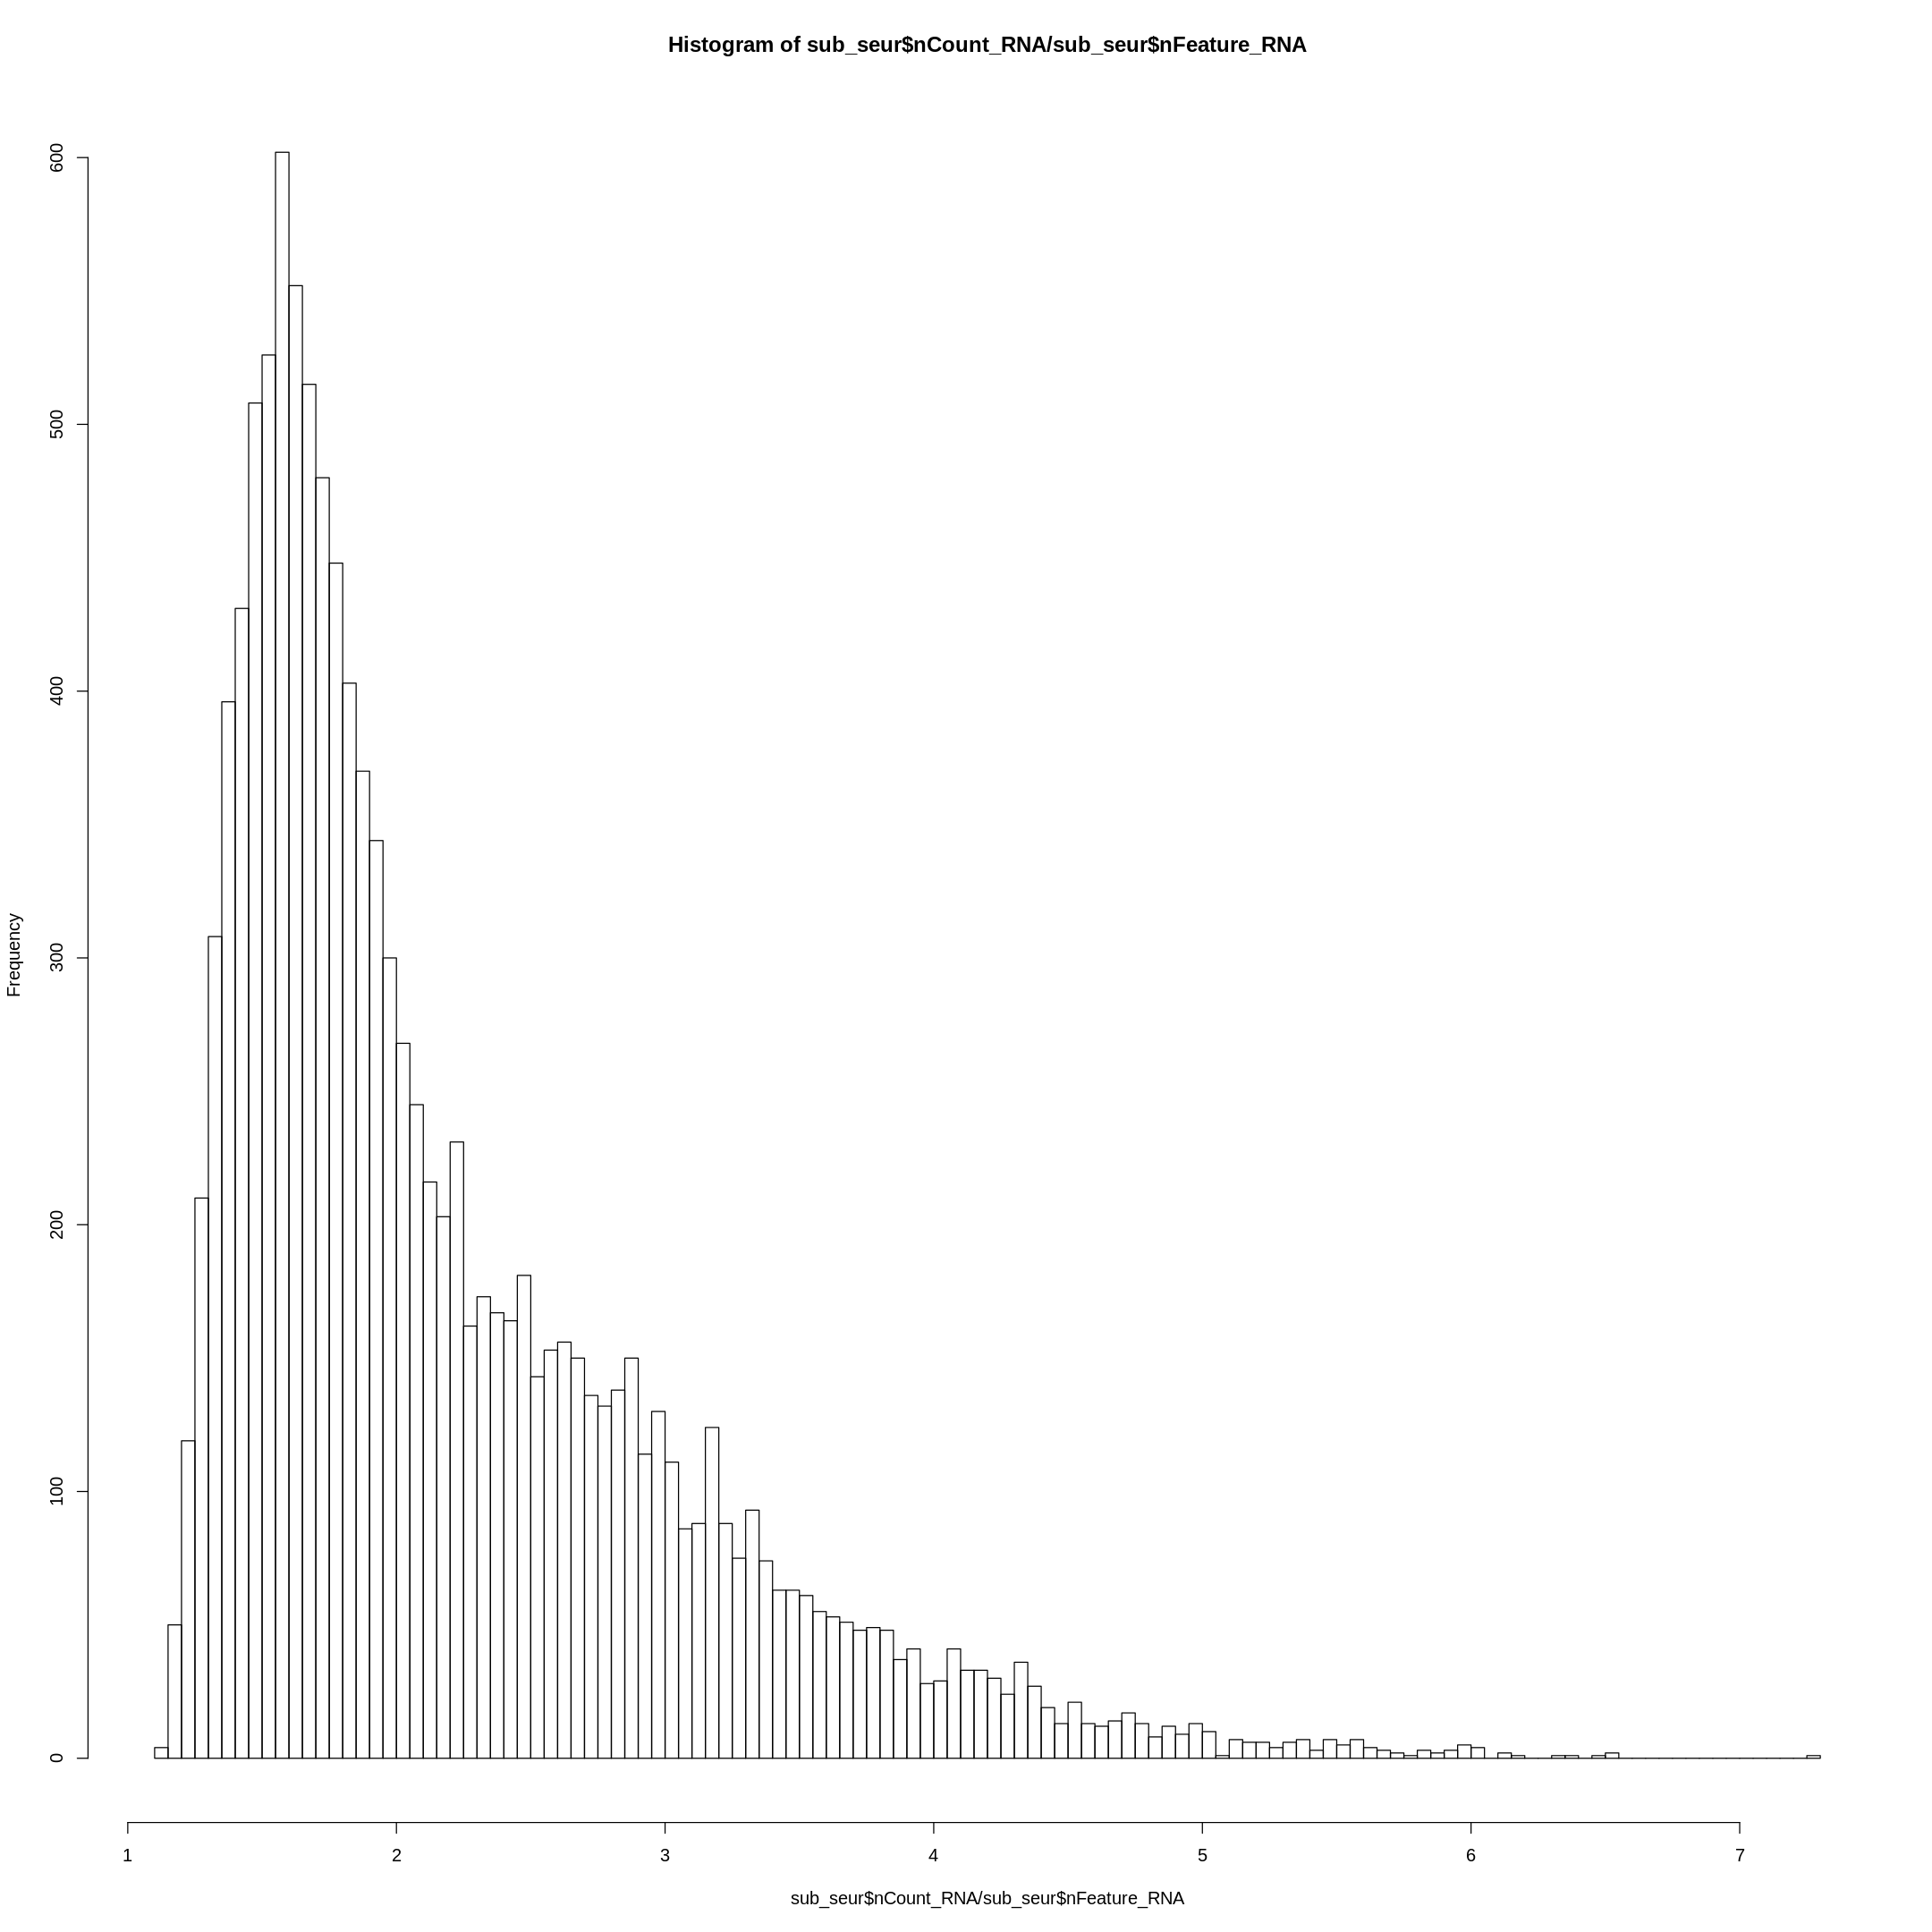

[1] 0.1058224

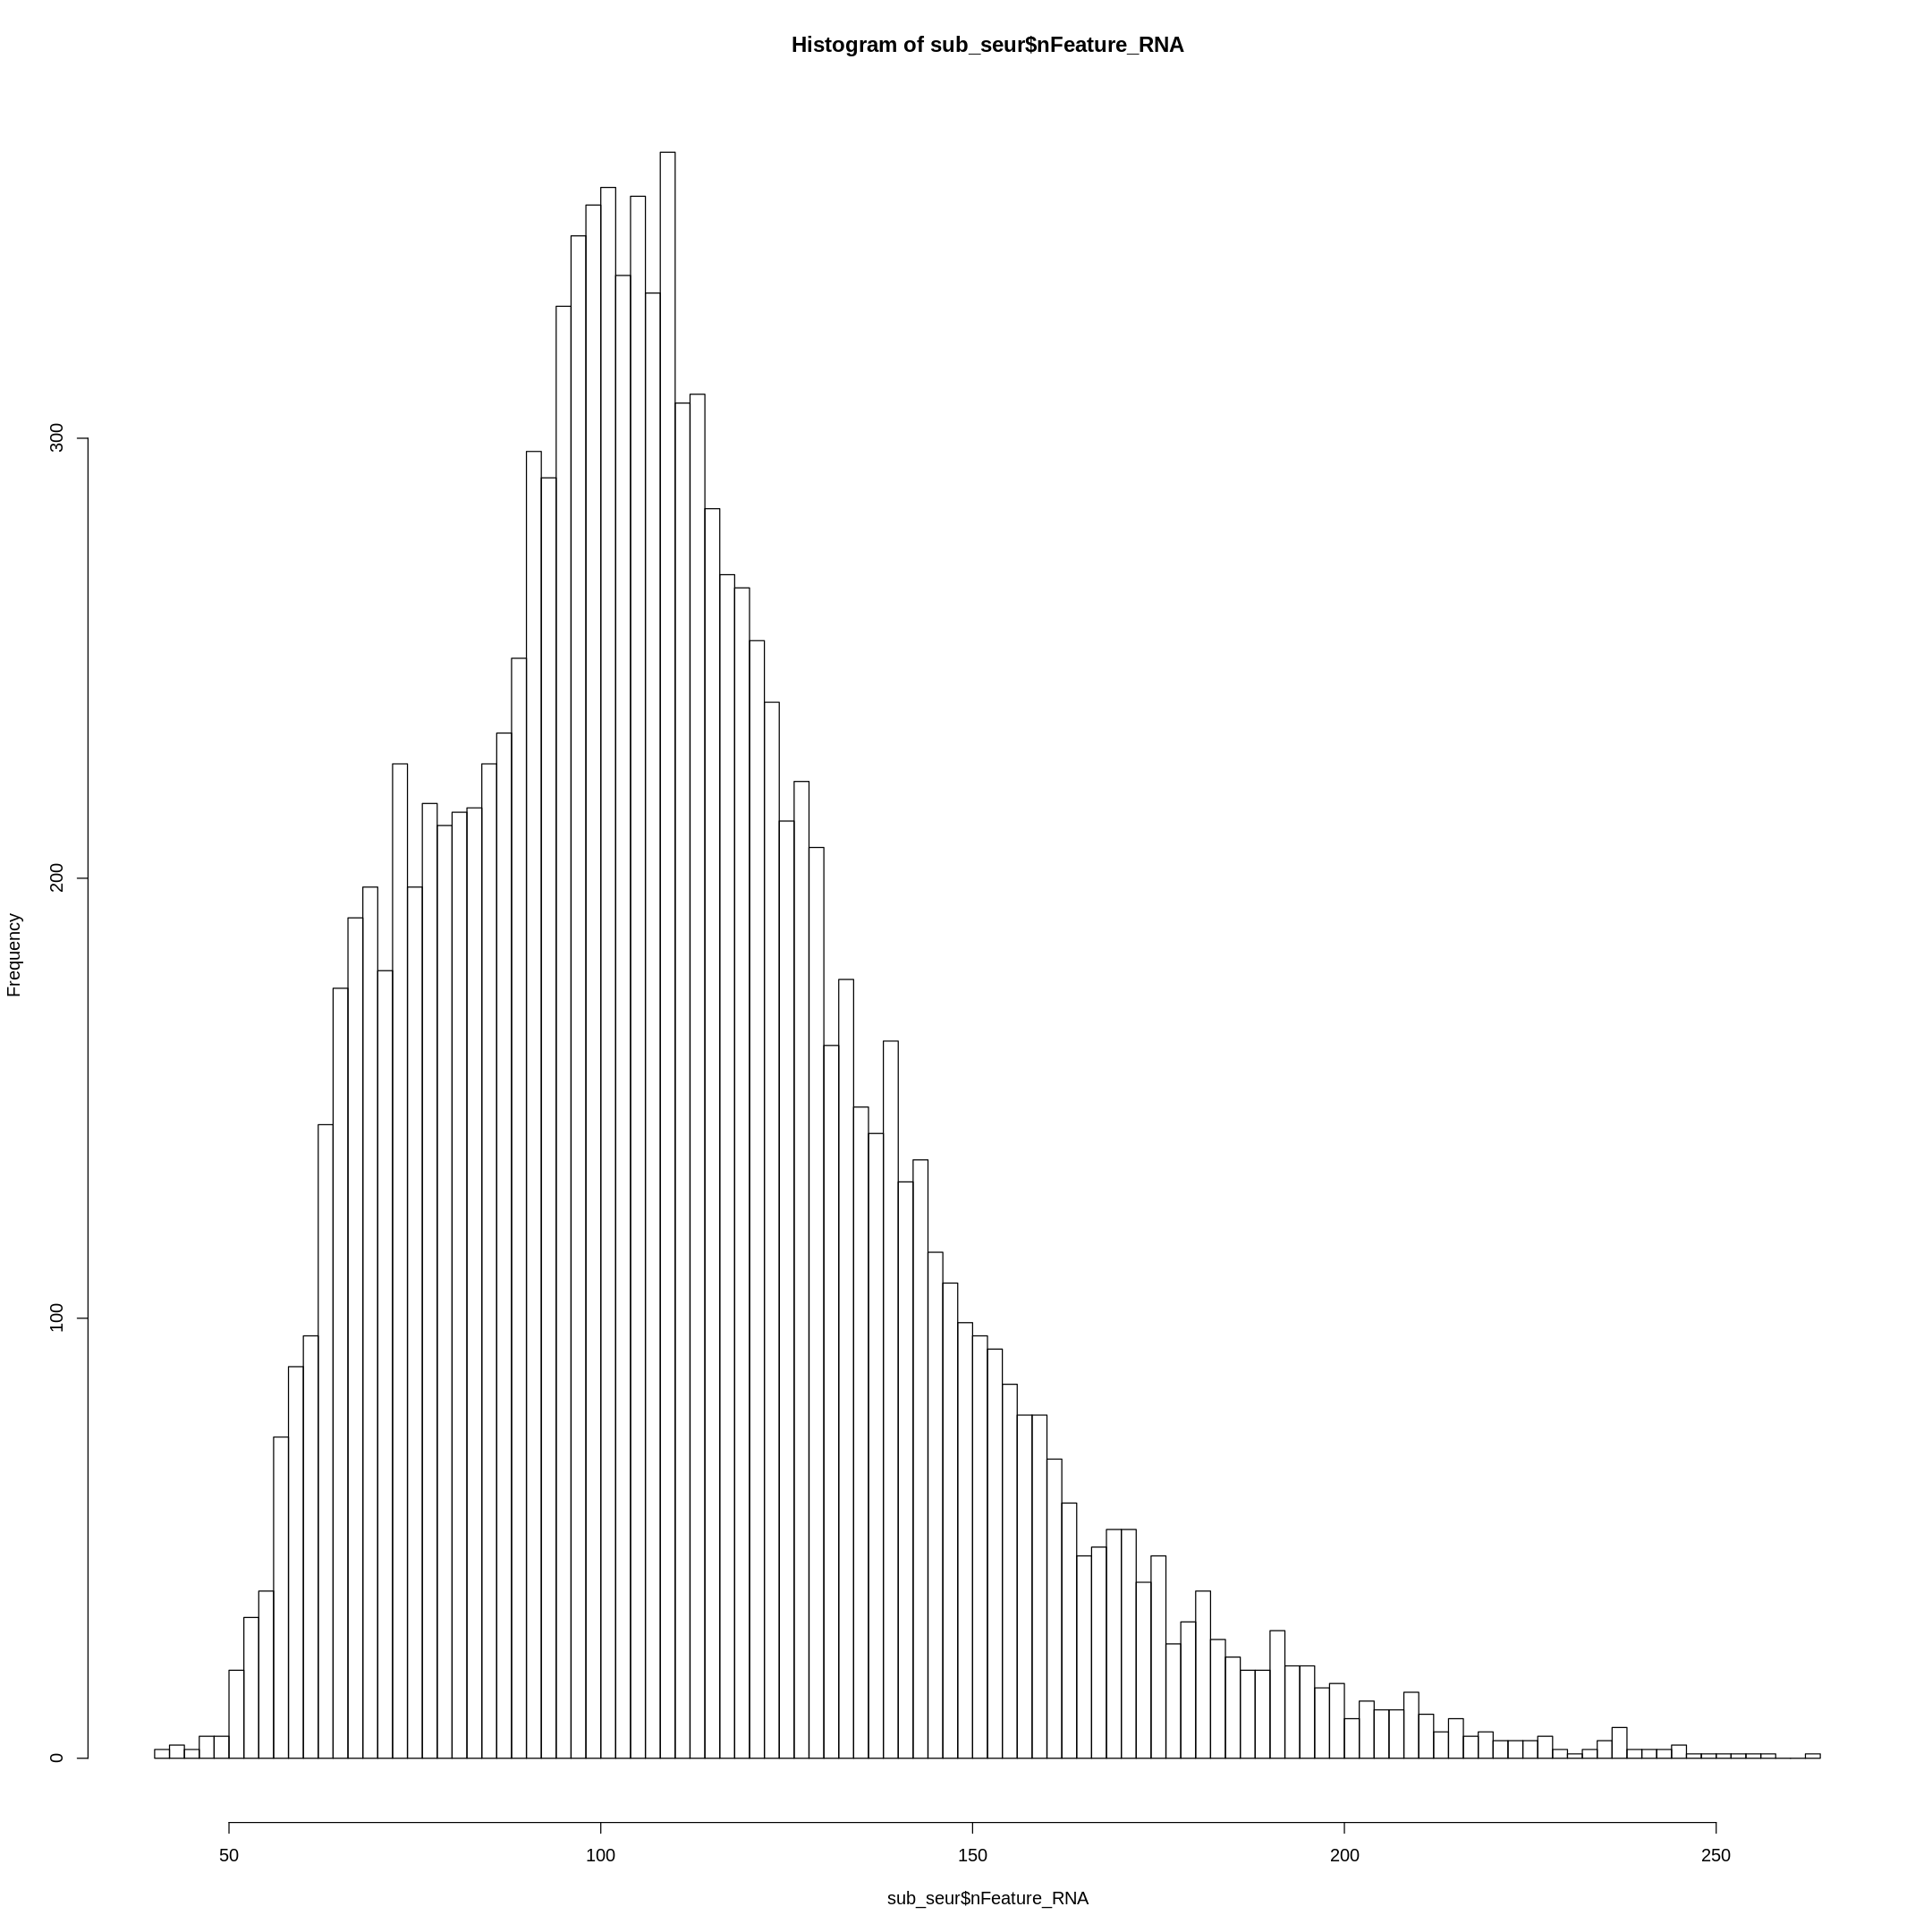

In [68]:
sub_seur <- subset(seur_list[[2]],features=YSG)
head(sub_seur@meta.data)
hist(sub_seur$nCount_RNA/sub_seur$nFeature_RNA,100)
hist(sub_seur$nFeature_RNA,100)
mean(sub_seur$nFeature_RNA/nrow(sub_seur))

orig.ident nCount_RNA nFeature_RNA
BoneMarrow_1.CGGCAGCCAGACAACGCC BoneMarrow  394       166         
BoneMarrow_1.CTGTGTAAGCGGCCGACG BoneMarrow 1521       284         
BoneMarrow_1.CGCACCTCGTAAAGTCGT BoneMarrow  270       137         
BoneMarrow_1.ACAATACGGCAGGGCTGC BoneMarrow 1397       244         
BoneMarrow_1.GTCCCGGGACATTCACTT BoneMarrow  235       130         
BoneMarrow_1.CCGACGACGTTGGGGCGA BoneMarrow  394       195         
                                Cell_barcode       Sample         
BoneMarrow_1.CGGCAGCCAGACAACGCC CGGCAGCCAGACAACGCC AdultBoneMarrow
BoneMarrow_1.CTGTGTAAGCGGCCGACG CTGTGTAAGCGGCCGACG AdultBoneMarrow
BoneMarrow_1.CGCACCTCGTAAAGTCGT CGCACCTCGTAAAGTCGT AdultBoneMarrow
BoneMarrow_1.ACAATACGGCAGGGCTGC ACAATACGGCAGGGCTGC AdultBoneMarrow
BoneMarrow_1.GTCCCGGGACATTCACTT GTCCCGGGACATTCACTT AdultBoneMarrow
BoneMarrow_1.CCGACGACGTTGGGGCGA CCGACGACGTTGGGGCGA AdultBoneMarrow
                                Batch           
BoneMarrow_1.CGGCAGCCAGACAACGCC AdultBoneMarrow1
BoneMarrow_1.CTGTGTAAGCGGCCGACG AdultBoneMarrow1
BoneMarrow_1.CGCACCTCGTAAAGTCGT AdultBoneMarrow1
BoneMarrow_1.ACAATACGGCAGGGCTGC AdultBoneMarrow1
BoneMarrow_1.GTCCCGGGACATTCACTT AdultBoneMarrow1
BoneMarrow_1.CCGACGACGTTGGGGCGA AdultBoneMarrow1
                                Cell_id                        
BoneMarrow_1.CGGCAGCCAGACAACGCC BoneMarrow_1.CGGCAGCCAGACAACGCC
BoneMarrow_1.CTGTGTAAGCGGCCGACG BoneMarrow_1.CTGTGTAAGCGGCCGACG
BoneMarrow_1.CGCACCTCGTAAAGTCGT BoneMarrow_1.CGCACCTCGTAAAGTCGT
BoneMarrow_1.ACAATACGGCAGGGCTGC BoneMarrow_1.ACAATACGGCAGGGCTGC
BoneMarrow_1.GTCCCGGGACATTCACTT BoneMarrow_1.GTCCCGGGACATTCACTT
BoneMarrow_1.CCGACGACGTTGGGGCGA BoneMarrow_1.CCGACGACGTTGGGGCGA
                                Cluster_id          Ages Development_stage ⋯
BoneMarrow_1.CGGCAGCCAGACAACGCC AdultBoneMarrow1_7  60Y  Adult             ⋯
BoneMarrow_1.CTGTGTAAGCGGCCGACG AdultBoneMarrow1_9  60Y  Adult             ⋯
BoneMarrow_1.CGCACCTCGTAAAGTCGT AdultBoneMarrow1_7  60Y  Adult             ⋯
BoneMarrow_1.ACAATACGGCAGGGCTGC AdultBoneMarrow1_8  60Y  Adult             ⋯
BoneMarrow_1.GTCCCGGGACATTCACTT AdultBoneMarrow1_7  60Y  Adult             ⋯
BoneMarrow_1.CCGACGACGTTGGGGCGA AdultBoneMarrow1_10 60Y  Adult             ⋯
                                Source Biomaterial      Name                
BoneMarrow_1.CGGCAGCCAGACAACGCC HCL    AdultBoneMarrow1 AdultBoneMarrow1_60Y
BoneMarrow_1.CTGTGTAAGCGGCCGACG HCL    AdultBoneMarrow1 AdultBoneMarrow1_60Y
BoneMarrow_1.CGCACCTCGTAAAGTCGT HCL    AdultBoneMarrow1 AdultBoneMarrow1_60Y
BoneMarrow_1.ACAATACGGCAGGGCTGC HCL    AdultBoneMarrow1 AdultBoneMarrow1_60Y
BoneMarrow_1.GTCCCGGGACATTCACTT HCL    AdultBoneMarrow1 AdultBoneMarrow1_60Y
BoneMarrow_1.CCGACGACGTTGGGGCGA HCL    AdultBoneMarrow1 AdultBoneMarrow1_60Y
                                ident Celltype            Celltype_NA
BoneMarrow_1.CGGCAGCCAGACAACGCC  7    B cell (Plasmocyte) FALSE      
BoneMarrow_1.CTGTGTAAGCGGCCGACG  9    T cell              FALSE      
BoneMarrow_1.CGCACCTCGTAAAGTCGT  7    B cell (Plasmocyte) FALSE      
BoneMarrow_1.ACAATACGGCAGGGCTGC  8    B cell (Centrocyte) FALSE      
BoneMarrow_1.GTCCCGGGACATTCACTT  7    B cell (Plasmocyte) FALSE      
BoneMarrow_1.CCGACGACGTTGGGGCGA 10    M2 Macrophage       FALSE      
                                percent.mt Celltype_Merge      Main_Im   
BoneMarrow_1.CGGCAGCCAGACAACGCC 3.529412   B cell (Plasmocyte) B         
BoneMarrow_1.CTGTGTAAGCGGCCGACG 3.932179   T cell              T         
BoneMarrow_1.CGCACCTCGTAAAGTCGT 7.792208   B cell (Plasmocyte) B         
BoneMarrow_1.ACAATACGGCAGGGCTGC 3.885714   B cell (Centrocyte) B         
BoneMarrow_1.GTCCCGGGACATTCACTT 1.257862   B cell (Plasmocyte) B         
BoneMarrow_1.CCGACGACGTTGGGGCGA 2.977667   M2 Macrophage       Macrophage
                                Celltype_used
BoneMarrow_1.CGGCAGCCAGACAACGCC Plasmocyte   
BoneMarrow_1.CTGTGTAAGCGGCCGACG T            
BoneMarrow_1.CGCACCTCGTAAAGTCGT Plasmocyte   
BoneMarrow_1.ACAATACGGCAGGGCTGC B

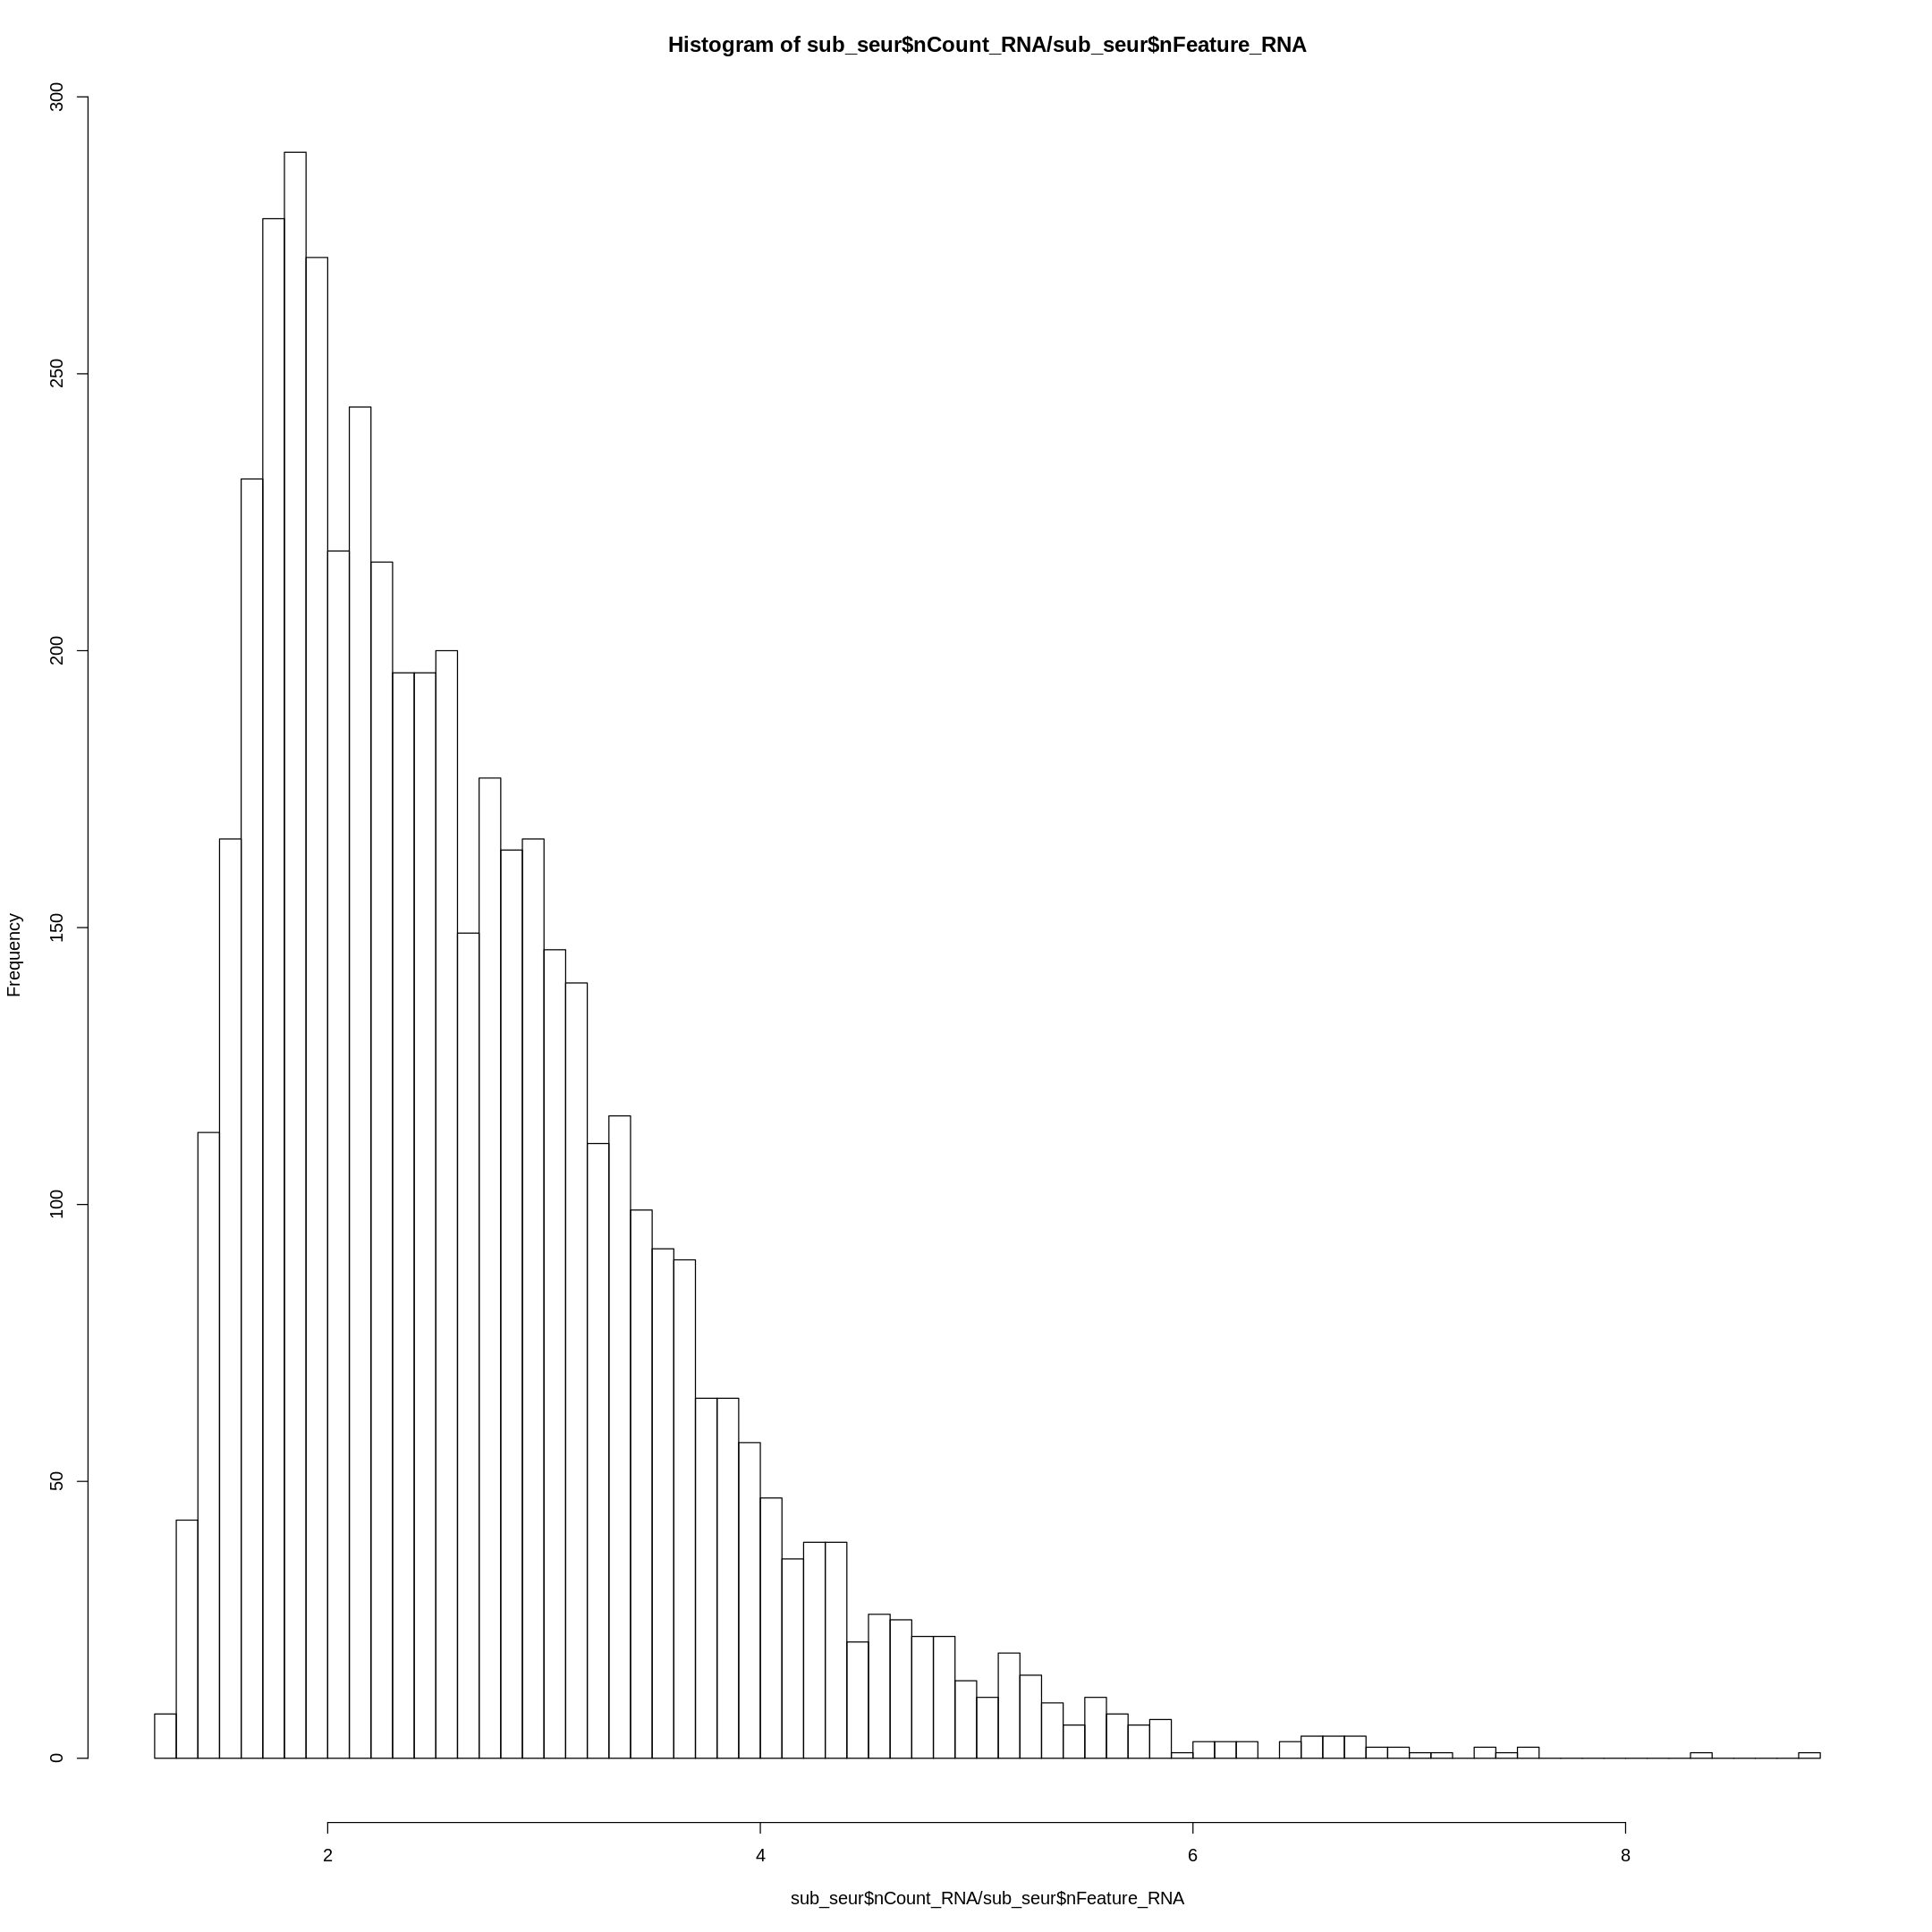

[1] 0.1352379

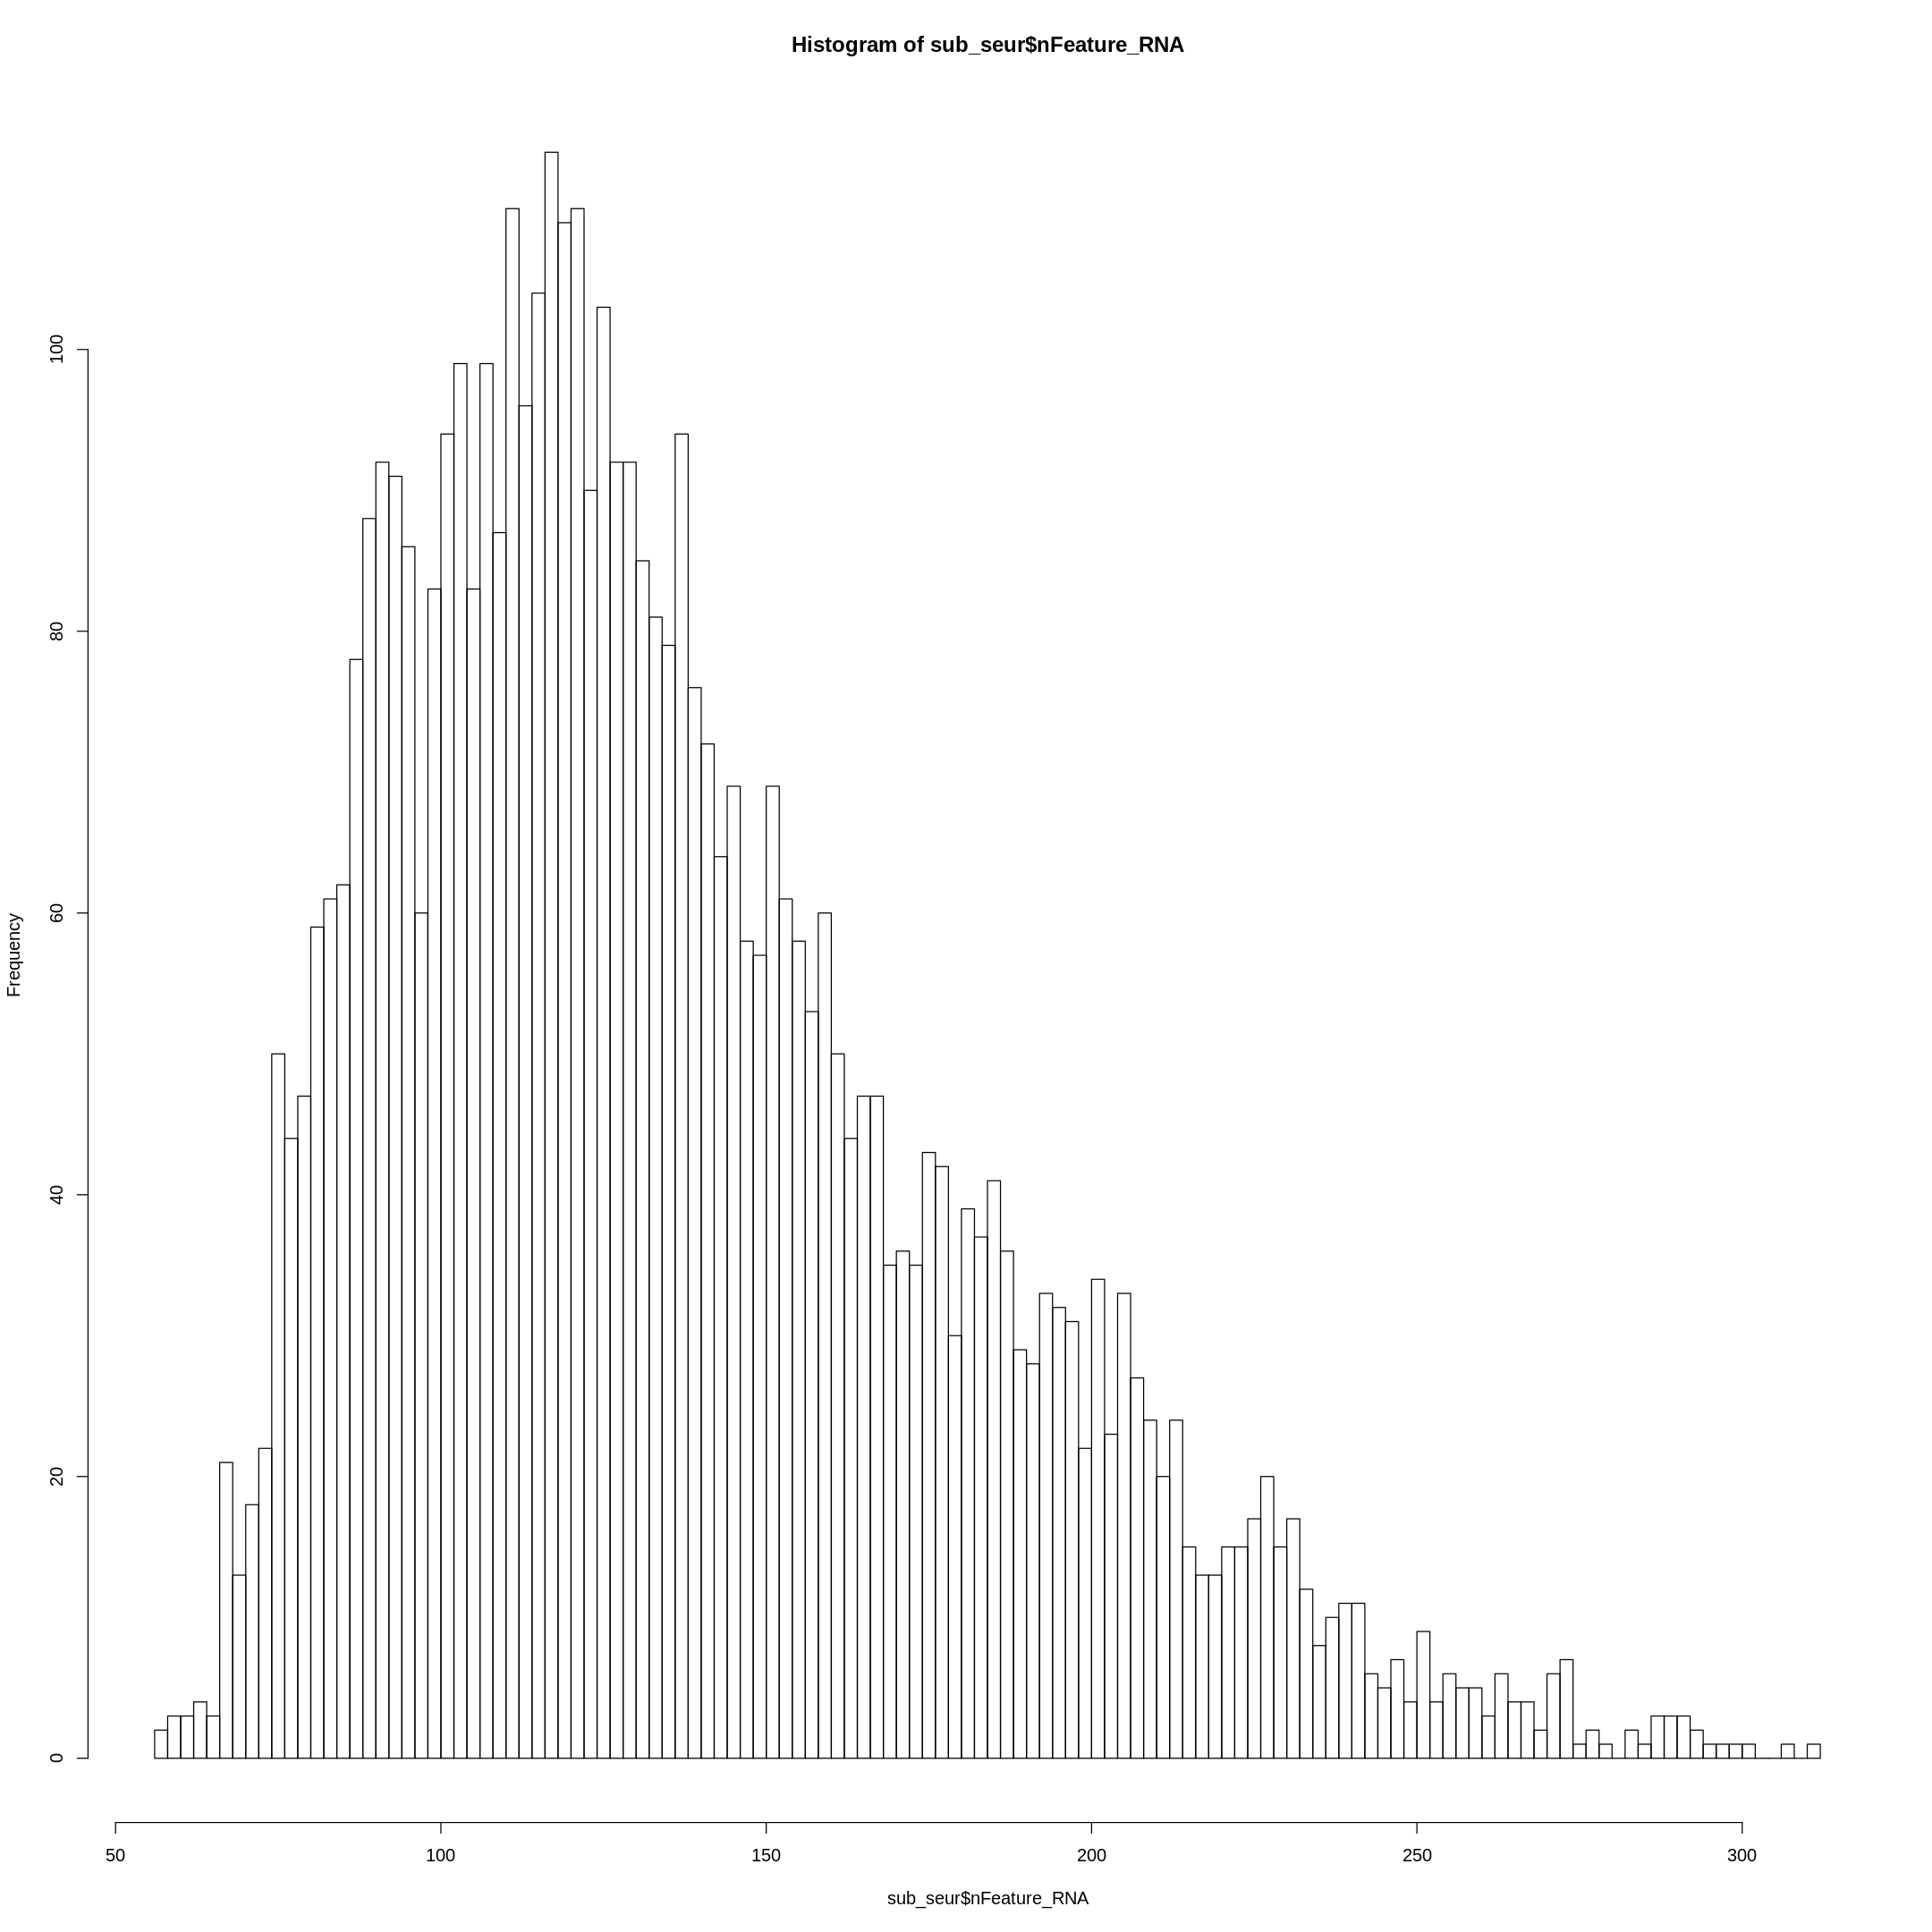

In [72]:
sub_seur <- subset(seur_list[[1]],features=YSG)
head(sub_seur@meta.data)
hist(sub_seur$nCount_RNA/sub_seur$nFeature_RNA,100)
hist(sub_seur$nFeature_RNA,100)
mean(sub_seur$nFeature_RNA/nrow(sub_seur))

In [60]:
## get tissue specific indicator matrix
g.list <- readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/pipeline_on_HCL/tissue_gene.rds")
w <- lapply(g.list,function(g) dcast(g.list[[1]], gene ~ celltype, value.var="cluster"))
w<- lapply(w,function(W) {rownames(W)=W$gene;return(W[,-1])})
w<- lapply(w,function(W) 1*(W==2))            

In [63]:
source('/gpfs/ysm/pi/zhao-data/wd262/sc_immune/sc_immune/Batch_Correction/run_liger.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'SAME/clean_format.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection
